# CQPS
- 20nm notches
- CQPS constriction in the middle

<img src="data/2021-02-05_cqps/extracted-plots.png">

<img src="data/2021-02-05_cqps/mfield-summary.svg">

In [16]:
%matplotlib notebook
import logging

import numpy as np
import matplotlib.pyplot as plt
plt.style.use("support-files/qubit.mplstyle")
from IPython.display import display
from ipywidgets import interact, interactive, interact_manual, FloatSlider, RadioButtons, Layout
import ipywidgets as widgets
from matplotlib import cm

from quantum_builder import QuantumBuilder

MY_COLOURS = {
    "DarkBlue": "#104e8b",     # dark blue (DodgerBlue4)
    "DarkRed": "#ed2200",     # dark red (red2)
    "Green": "#9acd32",     
    "Orange": "#ffc125",      # orange,
    "LightBlue": "#68838b",  # light steel blue,
    "Purple": "#6959cd",  # dark purple
    "Pink": "#ffa07a"  # pink salmon
}
nH = 10**(-9)
GHz = 10**9
MHz = 10**6
fF = 10**(-15)
e = 1.6*10**(-19)
h = 6.64*10**(-34)
Phi0 = h/2/e
nA = 10**(-9)

In [11]:
SIMULATION_PARAMETERS = {
    "states_per_loop": 9,
    "number_of_levels_to_simulate": 3
}
CQPS_TWIN_PARAMETERS = {
    "ES_center": 10,
    "ES_left": 10,
    "ES_right": 10,
    "inductive_loop_squares_left": 30,  # 30 140x140nm squares
    "inductive_loop_squares_right": 30,
    # Will be overriden by values below
    "EL_left": 5,
    "EL_right": 5,
    **SIMULATION_PARAMETERS
}

# Build Hamiltonian
cqps_tqubit = QuantumBuilder.build_cqps_twin_qubit(
    CQPS_TWIN_PARAMETERS,
    logging_level=logging.WARN)

<IPython.core.display.Javascript object>


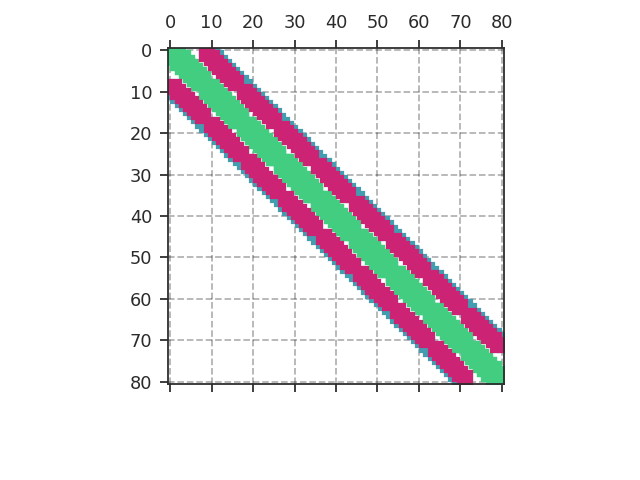

In [12]:
# Optional visualisation
from qubit.cqps_twin_qubit.cqps_twin_qubit_spare_matrix_visualizer import CQPSTwinQubitSparseMatrixVisualiser

cqps_tqubit.cqps_twin_qubit_hamiltonian_manager.stage1_prepare_hamiltonian_skeleton()

fig, ax = plt.subplots(1, 1, figsize=(4,3))
matrixVisualiser = CQPSTwinQubitSparseMatrixVisualiser(
    cqps_tqubit.cqps_twin_qubit_hamiltonian_manager, cqps_tqubit.cqps_twin_qubit_constant_manager)
matrixVisualiser.visualise_matrix(ax)
# plt.savefig("./output/cqps-twin_matrix-visualisation.svg")

<IPython.core.display.Javascript object>


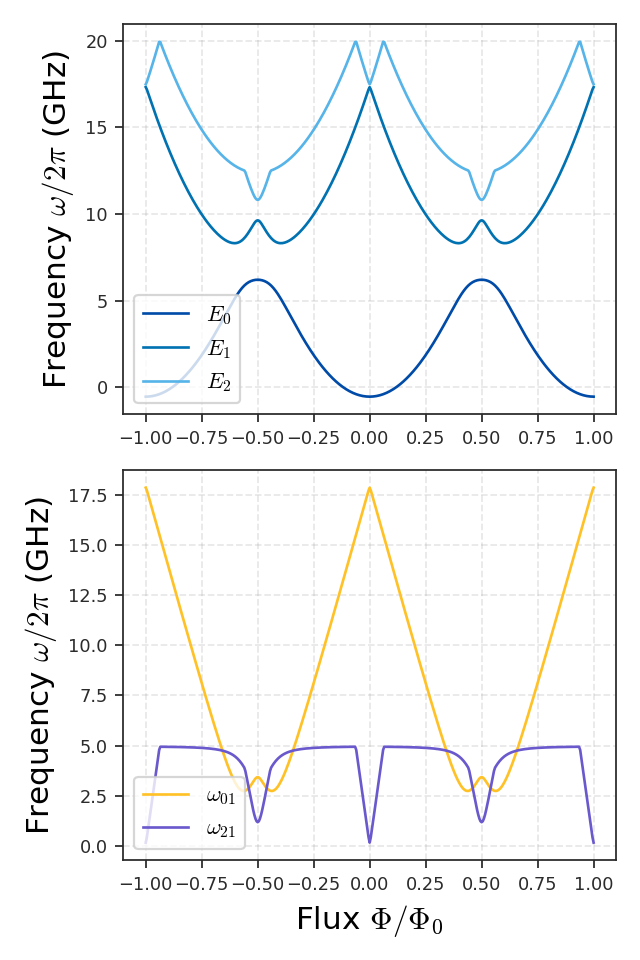

In [84]:
ES_left = 1.9
ES_center = 5
EL_left = 20
EL_right = 20

cqps_tqubit.override_parameters(
    EL_left=EL_left,
    EL_right=EL_right,
    ES_center=ES_center,
    ES_left=ES_left,
    ES_right=ES_left
)
FLUX_NUMBER = np.linspace(-1, 1, 401)

# Run simulation
simulation = cqps_tqubit.run_simulation(
    phi_dict={
        "type": "balanced",
        "phi_list": FLUX_NUMBER,
        "assymetry": 1.0
    }, number_of_levels_to_simulate=SIMULATION_PARAMETERS[
        "number_of_levels_to_simulate"],
    use_sparse_matrix=True  # No difference to accuracy
)

# Initial plot
fig, ax_arr = plt.subplots(2, 1, figsize=(4, 6))

ax = ax_arr[0]
simulation_0, = ax.plot(
    FLUX_NUMBER,
    simulation["eigvals"][:, 0, 0], label="$E_0$"
)
simulation_1, = ax.plot(
    FLUX_NUMBER,
    simulation["eigvals"][:, 0, 1], label="$E_1$"
)
simulation_2, = ax.plot(
    FLUX_NUMBER,
    simulation["eigvals"][:, 0, 2], label="$E_2$"
)
ax.legend(loc='lower left')

ax = ax_arr[1]
simulation_01, = ax.plot(
    FLUX_NUMBER,
    (simulation["eigvals"][:, 0, 1] -
     simulation["eigvals"][:, 0, 0]),
    color=MY_COLOURS["Orange"], label="$\omega_{01}$"
)
simulation_12, = ax.plot(
    FLUX_NUMBER,
    (simulation["eigvals"][:, 0, 2] -
     simulation["eigvals"][:, 0, 1]),
    color=MY_COLOURS["Purple"], label="$\omega_{21}$"
)
ax.legend(loc='lower left')

ax.set_xlabel("Flux $\Phi/\Phi_0$")
ax.set_ylabel("Frequency $\omega/2\pi$ (GHz)")
ax_arr[0].set_ylabel("Frequency $\omega/2\pi$ (GHz)")
plt.tight_layout()

In [79]:
def cqps_plot(EL_left, EL_right, ES_center, ES_right, ES_left,assymetry):
    cqps_tqubit.override_parameters(
        EL_left=EL_left, 
        EL_right=EL_right, 
        ES_center=ES_center, ES_left=ES_left, ES_right=ES_right)
    
    simulation = cqps_tqubit.run_simulation(
        phi_dict={
            "type": "balanced",
            "phi_list": FLUX_NUMBER,
            "assymetry": assymetry
        }, number_of_levels_to_simulate=SIMULATION_PARAMETERS["number_of_levels_to_simulate"], use_sparse_matrix=True)
    simulation_01.set_ydata(
        simulation["eigvals"][:, 0, 1]
        - simulation["eigvals"][:, 0, 0]
    )
    simulation_12.set_ydata(
        simulation["eigvals"][:, 0, 2]
        - simulation["eigvals"][:, 0, 1]
    )
    ax.relim()
    
EL_left_widget = FloatSlider(
    min=5, max=50,
    description="EL_left (GHz)", value=EL_left,
    layout=Layout(width='90%'),
    continuous_update=False
)
EL_right_widget = FloatSlider(
    min=5, max=50,
    description="EL_right (GHz)", value=EL_left,
    layout=Layout(width='90%'),
    continuous_update=False
)
ES_center_widget = FloatSlider(
    min=0, max=20,
    description="ES_center (GHz)", value=ES_center,
    layout=Layout(width='90%'),
    continuous_update=False
)
ES_left_widget = FloatSlider(
    min=0, max=5,
    description="ES_left (GHz)", value=ES_left,
    layout=Layout(width='90%'),
    continuous_update=False
)
ES_right_widget = FloatSlider(
    min=0, max=5,
    description="ES_right (GHz)", value=ES_left,
    layout=Layout(width='90%'),
    continuous_update=False
)
assymetry_widget = FloatSlider(
    min=0.95, max=1.05, step=0.005,
    description="Assymetry", value=1,
    layout=Layout(width='90%'),
    continuous_update=False
)
ui = widgets.VBox([
    EL_left_widget, EL_right_widget, ES_center_widget,
    ES_left_widget,ES_right_widget, assymetry_widget])

out = widgets.interactive_output(
    cqps_plot,
    {
        # Key is the subsituted parameter, Values is the widget to use
        "EL_right": EL_right_widget,
        "EL_left": EL_left_widget,
        "ES_center": ES_center_widget,
        "ES_left": ES_left_widget,
        "ES_right": ES_right_widget,
        "assymetry": assymetry_widget
    }
)  

display(ui, out)

Output()

In [85]:
# plt.savefig("./output/cqps-simulation_regime_EL=20_ES=1.9_ESC=0.8.pdf")
plt.savefig("./output/cqps-simulation_regime_EL=20_ES=1.9_ESC=5.0.pdf")
# plt.savefig("./output/cqps-simulation_regime_EL=20_30_ES=1.9_ESC=5.0.pdf")

# plt.savefig("./output/cqps-simulation_regime_EL=20_30_ES=0.2_ESC=3.6.pdf")
# plt.savefig("./output/cqps-simulation_regime_EL=20_ESS=1.9_ESC=9.pdf")

## Design simulation

In [42]:
def Ip_to_EL(Ip):
    EL = Phi0 * Ip / 2
    return EL / h / GHz
def EL_to_Ip(EL):
    return EL * h * GHz * 2 / Phi0

Ip_to_EL(20*nA)

31.25

In [44]:
Nsq = 40
L_square = 6*nH

L = Nsq * L_square
EL = Phi0**2 /2/L / h / GHz

print(EL)
print(EL_to_Ip(EL)/nA)

13.509114583333329
8.64583333333333


In [66]:
EL_to_Ip(10)/nA

6.3999999999999995

<IPython.core.display.Javascript object>


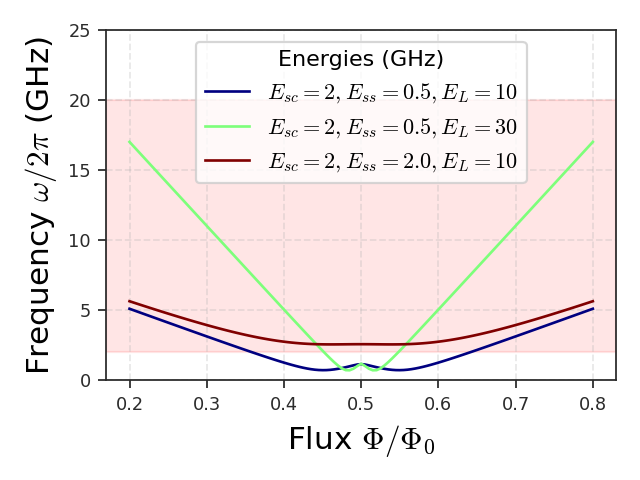

In [68]:
# ES_center, ES_left, EL_left
energy_list = [
    (2, 0.5, 10),
    (2, 0.5, 30),
    (2, 2, 10)
              ]
FLUX_NUMBER = np.linspace(.2, .8, 121)
f01_arr = []
f12_arr = []

for ES_center, ES_left, EL_left in energy_list:
    cqps_tqubit.override_parameters(
        EL_left=EL_left,
        EL_right=EL_left,
        ES_center=ES_center,
        ES_left=ES_left,
        ES_right=ES_left
    )
    simulation = cqps_tqubit.run_simulation(
        phi_dict={
            "type": "balanced",
            "phi_list": FLUX_NUMBER,
            "assymetry": 1.0
        }, number_of_levels_to_simulate=3,
        use_sparse_matrix=True  # No difference to accuracy
    )
    f01_arr.append(simulation["eigvals"][:, 0, 1] - simulation["eigvals"][:, 0, 0])
    f12_arr.append(simulation["eigvals"][:, 0, 2] - simulation["eigvals"][:, 0, 1])

# Initial plot
fig, ax = plt.subplots(1, 1, figsize=(4, 3))

ax.axhspan(2, 20, color='red', alpha=0.1)

cmap = plt.cm.jet(np.linspace(0, 1, len(energy_list)))
for i, _ in enumerate(f01_arr):
    ES_center, ES_left, EL_left = energy_list[i]
    ax.plot(
        FLUX_NUMBER,
        f01_arr[i],
        color=cmap[i], label=f"$E_{{sc}}={ES_center}, E_{{ss}}={ES_left:.1f}, E_L={EL_left}$"
    ),
#     ax.plot(
#         FLUX_NUMBER,
#         f12_arr[i],
#         color=cmap[i], linestyle='dotted'
#     )

ax.legend(loc='upper center', title="Energies (GHz)")
ax.set_xlabel("Flux $\Phi/\Phi_0$")
ax.set_ylabel("Frequency $\omega/2\pi$ (GHz)")
ax.set_ylim([0, 25])
plt.tight_layout()

In [69]:
plt.savefig("./output/cqps-twin_design-window.pdf")

## TiN95_TwinQ_3Feb'21_mfield_04_data-A.txt

In [8]:
FILENAME = "./data/2021-02-05_cqps/TiN95_TwinQ_3Feb'21_mfield_04_data-A.txt"

PERIOD = 0.37 - -0.0646
OFFSET = -0.638

with open(FILENAME) as fin:
    data3d_z = np.transpose(np.loadtxt(FILENAME))
    
    first_line = fin.readline().split()
    data3d_x = np.linspace(float(first_line[1]), float(first_line[2]), data3d_z.shape[1])
    data3d_x = (data3d_x) / PERIOD - OFFSET
    
    second_line = fin.readline().split()
    data3d_y = np.linspace(float(second_line[1]), float(second_line[2]), data3d_z.shape[0])

# Build meshes and arrays based of the ranges in the file
data3d_xmesh, data3d_ymesh = np.meshgrid(data3d_x, data3d_y)

In [9]:
# Seed initial values
EL_left = 21.6
ES = 13.3
ES_on_sides = 11.1
cqps_tqubit.override_parameters(
    EL_left=EL_left,
    EL_right=EL_left,
    ES=ES,
    ES_on_sides=ES_on_sides
)
FLUX_NUMBER = np.linspace(-1, 2, 101)

# Run simulation
simulation = cqps_tqubit.run_simulation(
    phi_dict={
        "type": "balanced",
        "phi_list": FLUX_NUMBER,
    }, number_of_levels_to_simulate=SIMULATION_PARAMETERS[
        "number_of_levels_to_simulate"],
    use_sparse_matrix=True  # No difference to accuracy
)

# Initial plot
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
ax.pcolormesh(data3d_xmesh, data3d_ymesh, data3d_z,
              shading='nearest',
              cmap=cm.bone)
simulation_01, = ax.plot(
    FLUX_NUMBER,
    (simulation["eigvals"][:, 0, 1] -
     simulation["eigvals"][:, 0, 0]),
    color=MY_COLOURS["Orange"], alpha=0.3
)
simulation_12, = ax.plot(
    FLUX_NUMBER,
    (simulation["eigvals"][:, 0, 2] -
     simulation["eigvals"][:, 0, 1]),
)

ax.set_xlim([data3d_x[0], data3d_x[-1]])
ax.set_ylim([data3d_y[0], data3d_y[-1]])
ax.set_xlabel("Flux $\Phi/\Phi_0$")
ax.set_ylabel("Frequency $\omega/2\pi$ (GHz)")

plt.tight_layout()

<IPython.core.display.Javascript object>

In [57]:
# Interactive plot
def cqps_plot(EL_left, EL_right, ES, ES_on_sides):
    cqps_tqubit.override_parameters(
        EL_left=EL_left, EL_right=EL_left, ES=ES, ES_on_sides=ES_on_sides)
    
    simulation = cqps_tqubit.run_simulation(
        phi_dict={
            "type": "balanced",
            "phi_list": FLUX_NUMBER,
        }, number_of_levels_to_simulate=SIMULATION_PARAMETERS["number_of_levels_to_simulate"], use_sparse_matrix=True)
    
    simulation_01.set_ydata(
        simulation["eigvals"][:, 0, 1] - simulation["eigvals"][:, 0, 0])
    simulation_12.set_ydata(
        simulation["eigvals"][:, 0, 2] - simulation["eigvals"][:, 0, 1])

EL_left_widget = FloatSlider(
    min=0, max=100,
    description="EL_left (GHz)", value=EL_left,
    layout=Layout(width='90%'),
    continuous_update=False
)
EL_right_widget = FloatSlider(
    min=0, max=100,
    description="EL_right (GHz)", value=EL_left,
    layout=Layout(width='90%'),
    continuous_update=False
)
ES_widget = FloatSlider(
    min=0, max=100,
    description="ES (GHz)", value=ES,
    layout=Layout(width='90%'),
    continuous_update=False
)
ES_on_sides_widget = FloatSlider(
    min=0, max=20,
    description="ES_on_sides (GHz)", value=ES_on_sides,
    layout=Layout(width='90%'),
    continuous_update=False
)
ui = widgets.VBox([EL_left_widget, EL_right_widget, ES_widget, ES_on_sides_widget])

out = widgets.interactive_output(
    cqps_plot,
    {
        # Key is the subsituted parameter, Values is the widget to use
        "EL_right": EL_right_widget,
        "EL_left": EL_left_widget,
        "ES": ES_widget,
        "ES_on_sides": ES_on_sides_widget
    }
)  

display(ui, out)

Output()

In [41]:
plt.savefig(FILENAME.replace("txt","pdf"), dpi=100)

## TiN95_TwinQ_3Feb'21_mfield_04_data-B.txt
Associated with qubit 1 in design:
- 38.45 squares of NbN
- 12nm constriction - similar to constrictions in cqps paper which range from 0.1-4GHz
- 20nm outer constrictions so should be below 1GHz

In [8]:
# Repetition period
x = [ -0.482, -0.062, 0.3551]
for i in range(0, len(x)-1):
    print(x[i+1] - x[i])   
    
# TiN inductance to evaluate energy
L = 38.45 * 6*nH
EL = cqps_tqubit.cqps_twin_qubit_constant_manager.generic_converter.convert_energy_to_GHz(
    Phi0**2 / 2 / L)
print(EL)

L = 38.45 * 2*nH
EL = cqps_tqubit.cqps_twin_qubit_constant_manager.generic_converter.convert_energy_to_GHz(
    Phi0**2 / 2 / L)
print(EL)

0.42
0.4171
14.053695275249238
42.16108582574772


In [21]:
# FILENAME = "./data/2021-02-05_cqps/TiN95_TwinQ_3Feb'21_mfield_04_data-B.txt"
# ES_center = 36
# ES_left = 5.1
# PERIOD = 0.419
# OFFSET = -.155
# EL_left = 25.8

FILENAME = "./data/2021-02-05_cqps/TiN95_TwinQ_3Feb'21_mfield_04_data-B1.txt"
PERIOD = 0.42
OFFSET = -.155 + 0.5

ES_center = 5
ES_left = 0.2
EL_left = 25.8

with open(FILENAME) as fin:
    data3d_z = np.transpose(np.loadtxt(FILENAME))
    
    first_line = fin.readline().split()
    data3d_x = np.linspace(float(first_line[1]), float(first_line[2]), data3d_z.shape[1])
    data3d_x = (data3d_x) / PERIOD - OFFSET
    
    second_line = fin.readline().split()
    data3d_y = np.linspace(float(second_line[1]), float(second_line[2]), data3d_z.shape[0])

# Build meshes and arrays based of the ranges in the file
data3d_xmesh, data3d_ymesh = np.meshgrid(data3d_x, data3d_y)

In [22]:
cqps_tqubit.override_parameters(
    EL_left=EL_left,
    EL_right=EL_left,
    ES_center=ES_center,
    ES_left=ES_left,
    ES_right=ES_left
)
FLUX_NUMBER = np.linspace(-1, 1, 201)

# Run simulation
simulation = cqps_tqubit.run_simulation(
    phi_dict={
        "type": "balanced",
        "phi_list": FLUX_NUMBER,
        "assymetry": 1.0
    }, number_of_levels_to_simulate=SIMULATION_PARAMETERS[
        "number_of_levels_to_simulate"],
    use_sparse_matrix=True  # No difference to accuracy
)

# Initial plot
fig, ax_arr = plt.subplots(1, 1, figsize=(1.5, 1))
# ax = ax_arr[0]
# simulation_0, = ax.plot(
#     FLUX_NUMBER,
#     simulation["eigvals"][:, 0, 0]
# )
# simulation_1, = ax.plot(
#     FLUX_NUMBER,
#     simulation["eigvals"][:, 0, 1]
# )
# simulation_2, = ax.plot(
#     FLUX_NUMBER,
#     simulation["eigvals"][:, 0, 2]
# )
# simulation_3, = ax.plot(
#     FLUX_NUMBER,
#     simulation["eigvals"][:, 0, 3]
# )
ax = ax_arr
ax.pcolormesh(data3d_xmesh, data3d_ymesh, data3d_z,
              shading='nearest',
              cmap=cm.bone)
simulation_01, = ax.plot(
    FLUX_NUMBER,
    (simulation["eigvals"][:, 0, 1] -
     simulation["eigvals"][:, 0, 0]),
    color=MY_COLOURS["Orange"], alpha=0.3
)
simulation_12, = ax.plot(
    FLUX_NUMBER,
    (simulation["eigvals"][:, 0, 2] -
     simulation["eigvals"][:, 0, 1]),
)
# simulation_32, = ax.plot(
#     FLUX_NUMBER,
#     (simulation["eigvals"][:, 0, 3] -
#      simulation["eigvals"][:, 0, 2]), color="red"
# )
# simulation_20, = ax.plot(
#     FLUX_NUMBER,
#     (simulation["eigvals"][:, 0, 2] -
#      simulation["eigvals"][:, 0, 0]), color="green"
# )
# simulation_31, = ax.plot(
#     FLUX_NUMBER,
#     (simulation["eigvals"][:, 0, 3] -
#      simulation["eigvals"][:, 0, 1]), color="purple"
# )


ax.set_xlim([data3d_x[0], data3d_x[-1]])
ax.set_ylim([data3d_y[0], data3d_y[-1]])
# ax.set_ylim([5, 20])
ax.set_xlabel("Flux $\Phi/\Phi_0$")
ax.set_ylabel("Frequency $\omega/2\pi$ (GHz)")

# plt.tight_layout()
# plt.savefig("./data/2021-02-05_cqps/energy-level-simulation.svg")

<IPython.core.display.Javascript object>

Text(0, 0.5, 'Frequency $\\omega/2\\pi$ (GHz)')

In [23]:
# Interactive plot
def cqps_plot(EL_left, EL_right, ES_center, ES_right, ES_left,assymetry):
    cqps_tqubit.override_parameters(
        EL_left=EL_left, 
        EL_right=EL_right, 
        ES_center=ES_center, ES_left=ES_left, ES_right=ES_right)
    
    simulation = cqps_tqubit.run_simulation(
        phi_dict={
            "type": "balanced",
            "phi_list": FLUX_NUMBER,
            "assymetry": assymetry
        }, number_of_levels_to_simulate=SIMULATION_PARAMETERS["number_of_levels_to_simulate"], use_sparse_matrix=True)
#     simulation_0.set_ydata(simulation["eigvals"][:, 0, 0])
#     simulation_1.set_ydata(simulation["eigvals"][:, 0, 1])
#     simulation_2.set_ydata(simulation["eigvals"][:, 0, 2])
#     simulation_3.set_ydata(simulation["eigvals"][:, 0, 3])
    simulation_01.set_ydata(
        simulation["eigvals"][:, 0, 1]
        - simulation["eigvals"][:, 0, 0]
    )
    simulation_12.set_ydata(
        simulation["eigvals"][:, 0, 2]
        - simulation["eigvals"][:, 0, 1]
    )
#     simulation_32.set_ydata(
#         simulation["eigvals"][:, 0, 3]
#         - simulation["eigvals"][:, 0, 2]
#     )
#     simulation_20.set_ydata(
#         simulation["eigvals"][:, 0, 2]
#         - simulation["eigvals"][:, 0, 0]
#     )
#     simulation_31.set_ydata(
#         simulation["eigvals"][:, 0, 3]
#         - simulation["eigvals"][:, 0, 1]
#     )

EL_left_widget = FloatSlider(
    min=5, max=50,
    description="EL_left (GHz)", value=EL_left,
    layout=Layout(width='90%'),
    continuous_update=False
)
EL_right_widget = FloatSlider(
    min=5, max=50,
    description="EL_right (GHz)", value=EL_left,
    layout=Layout(width='90%'),
    continuous_update=False
)
ES_center_widget = FloatSlider(
    min=0, max=20,
    description="ES_center (GHz)", value=ES_center,
    layout=Layout(width='90%'),
    continuous_update=False
)
ES_left_widget = FloatSlider(
    min=0, max=2,
    description="ES_left (GHz)", value=ES_left,
    layout=Layout(width='90%'),
    continuous_update=False
)
ES_right_widget = FloatSlider(
    min=0, max=2,
    description="ES_right (GHz)", value=ES_left,
    layout=Layout(width='90%'),
    continuous_update=False
)
assymetry_widget = FloatSlider(
    min=0.95, max=1.05, step=0.005,
    description="Assymetry", value=1,
    layout=Layout(width='90%'),
    continuous_update=False
)
ui = widgets.VBox([
    EL_left_widget, EL_right_widget, ES_center_widget,
    ES_left_widget,ES_right_widget, assymetry_widget])

out = widgets.interactive_output(
    cqps_plot,
    {
        # Key is the subsituted parameter, Values is the widget to use
        "EL_right": EL_right_widget,
        "EL_left": EL_left_widget,
        "ES_center": ES_center_widget,
        "ES_left": ES_left_widget,
        "ES_right": ES_right_widget,
        "assymetry": assymetry_widget
    }
)  

display(ui, out)

Output()

In [80]:
plt.savefig(FILENAME.replace("txt","pdf"), dpi=100)

## TiN95_TwinQ_3Feb'21_mfield_06_data-C.txt
Associated with qubit 7:
- 11nm constrictions
- 20nm outside constrictions
- 42.35 squares

In [6]:
# Minima positions
x = [-0.3713, -0.1663, 0.0386, 0.2452]
for i in range(0, len(x)-1):
    print(x[i+1] - x[i])
    
# TiN inductance to evaluate energy
L = 42.35 * 6*nH
EL = cqps_tqubit.cqps_twin_qubit_constant_manager.generic_converter.convert_energy_to_GHz(
    Phi0**2 / 2 / L)
print(EL)

L = 42.35 * 2*nH
EL = cqps_tqubit.cqps_twin_qubit_constant_manager.generic_converter.convert_energy_to_GHz(
    Phi0**2 / 2 / L)
print(EL)

0.20500000000000002
0.2049
0.2066
12.759494293585199
38.2784828807556


In [12]:
# FILENAME = "./data/2021-02-05_cqps/TiN95_TwinQ_3Feb'21_mfield_06_data-C.txt"
PERIOD = 0.205*2
OFFSET = -0.050
# EL_left = 10.4
# ES_center = 6.2
# ES_left = 0.5

FILENAME = "./data/2021-02-05_cqps/TiN95_TwinQ_3Feb'21_mfield_04_data-C.txt"
PERIOD = 0.207*2
OFFSET = -0.050 - 0.1

# Matching the top "squares"
EL_left = 20
ES_center = 12.8
ES_left = 0.9

with open(FILENAME) as fin:
    data3d_z = np.transpose(np.loadtxt(FILENAME))
    
    first_line = fin.readline().split()
    data3d_x = np.linspace(float(first_line[1]), float(first_line[2]), data3d_z.shape[1])
    data3d_x = (data3d_x) / PERIOD - OFFSET
    
    second_line = fin.readline().split()
    data3d_y = np.linspace(float(second_line[1]), float(second_line[2]), data3d_z.shape[0])

# Build meshes and arrays based of the ranges in the file
data3d_xmesh, data3d_ymesh = np.meshgrid(data3d_x, data3d_y)

<IPython.core.display.Javascript object>


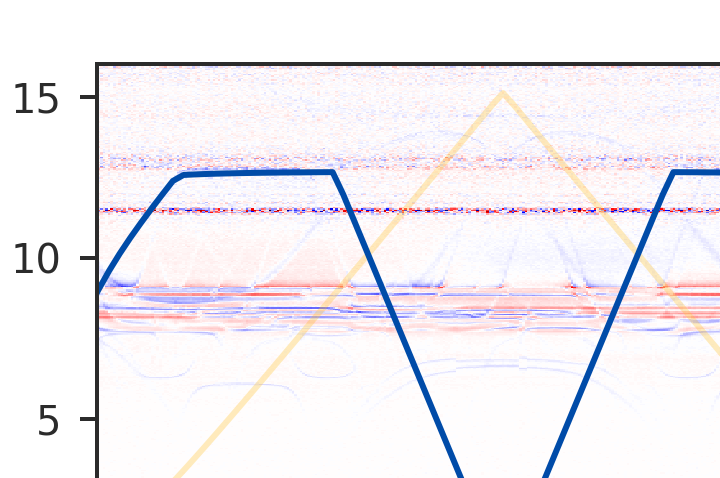

Text(0, 0.5, 'Frequency $\\omega/2\\pi$ (GHz)')

In [13]:
cqps_tqubit.override_parameters(
    EL_left=EL_left,
    EL_right=EL_left,
    ES_center=ES_center,
    ES_left=ES_left,
    ES_right=ES_left
)
# FLUX_NUMBER = np.linspace(0.1, 0.4, 301)
# FLUX_NUMBER = np.linspace(-0.5, 0.5, 401)
FLUX_NUMBER = np.linspace(-0.5, 0.5, 101)

# Run simulation
simulation = cqps_tqubit.run_simulation(
    phi_dict={
        "type": "balanced",
        "phi_list": FLUX_NUMBER,
        "assymetry": 1.0
    }, number_of_levels_to_simulate=SIMULATION_PARAMETERS[
        "number_of_levels_to_simulate"],
    use_sparse_matrix=True  # No difference to accuracy
)

# Initial plot
fig, ax_arr = plt.subplots(1, 1, figsize=(1.5, 1))
ax = ax_arr
ax.pcolormesh(data3d_xmesh, data3d_ymesh, data3d_z,
              shading='nearest',
              cmap=cm.seismic)
simulation_01, = ax.plot(
    FLUX_NUMBER,
    (simulation["eigvals"][:, 0, 1] -
     simulation["eigvals"][:, 0, 0]),
    color=MY_COLOURS["Orange"], alpha=0.3
)
simulation_12, = ax.plot(
    FLUX_NUMBER,
    (simulation["eigvals"][:, 0, 2] -
     simulation["eigvals"][:, 0, 1]),
)
# simulation_32, = ax.plot(
#     FLUX_NUMBER,
#     (simulation["eigvals"][:, 0, 3] -
#      simulation["eigvals"][:, 0, 2]), color="red"
# )
# simulation_20, = ax.plot(
#     FLUX_NUMBER,
#     (simulation["eigvals"][:, 0, 2] -
#      simulation["eigvals"][:, 0, 0]), color="green"
# )
# simulation_31, = ax.plot(
#     FLUX_NUMBER,
#     (simulation["eigvals"][:, 0, 3] -
#      simulation["eigvals"][:, 0, 1]), color="purple"
# )

ax.set_xlim([data3d_x[0], data3d_x[-1]])
ax.set_ylim([data3d_y[0], data3d_y[-1]])
# ax.set_ylim([10, 15])
ax.set_xlabel("Flux $\Phi/\Phi_0$")
ax.set_ylabel("Frequency $\omega/2\pi$ (GHz)")

# plt.tight_layout()
# plt.savefig("./data/2021-02-05_cqps/energy-level-simulation.svg")

In [10]:
# Interactive plot
def cqps_plot(EL_left, EL_right, ES_center, ES_right, ES_left,assymetry):
    cqps_tqubit.override_parameters(
        EL_left=EL_left, 
        EL_right=EL_right, 
        ES_center=ES_center, ES_left=ES_left, ES_right=ES_right)
    
    simulation = cqps_tqubit.run_simulation(
        phi_dict={
            "type": "balanced",
            "phi_list": FLUX_NUMBER,
            "assymetry": assymetry
        }, number_of_levels_to_simulate=SIMULATION_PARAMETERS["number_of_levels_to_simulate"], use_sparse_matrix=True)
    simulation_01.set_ydata(
        simulation["eigvals"][:, 0, 1]
        - simulation["eigvals"][:, 0, 0]
    )
    simulation_12.set_ydata(
        simulation["eigvals"][:, 0, 2]
        - simulation["eigvals"][:, 0, 1]
    )
#     simulation_32.set_ydata(
#         simulation["eigvals"][:, 0, 3]
#         - simulation["eigvals"][:, 0, 2]
#     )
#     simulation_20.set_ydata(
#         simulation["eigvals"][:, 0, 2]
#         - simulation["eigvals"][:, 0, 0]
#     )
#     simulation_31.set_ydata(
#         simulation["eigvals"][:, 0, 3]
#         - simulation["eigvals"][:, 0, 1]
#     )

EL_left_widget = FloatSlider(
    min=5, max=50,
    description="EL_left (GHz)", value=EL_left,
    layout=Layout(width='90%'),
    continuous_update=False
)
EL_right_widget = FloatSlider(
    min=5, max=50,
    description="EL_right (GHz)", value=EL_left,
    layout=Layout(width='90%'),
    continuous_update=False
)
ES_center_widget = FloatSlider(
    min=0, max=20,
    description="ES_center (GHz)", value=ES_center,
    layout=Layout(width='90%'),
    continuous_update=False
)
ES_left_widget = FloatSlider(
    min=0, max=5,
    description="ES_left (GHz)", value=ES_left,
    layout=Layout(width='90%'),
    continuous_update=False
)
ES_right_widget = FloatSlider(
    min=0, max=5,
    description="ES_right (GHz)", value=ES_left,
    layout=Layout(width='90%'),
    continuous_update=False
)
assymetry_widget = FloatSlider(
    min=0.95, max=1.05, step=0.005,
    description="Assymetry", value=1,
    layout=Layout(width='90%'),
    continuous_update=False
)
ui = widgets.VBox([
    EL_left_widget, EL_right_widget, ES_center_widget,
    ES_left_widget,ES_right_widget, assymetry_widget])

out = widgets.interactive_output(
    cqps_plot,
    {
        # Key is the subsituted parameter, Values is the widget to use
        "EL_right": EL_right_widget,
        "EL_left": EL_left_widget,
        "ES_center": ES_center_widget,
        "ES_left": ES_left_widget,
        "ES_right": ES_right_widget,
        "assymetry": assymetry_widget
    }
)  

display(ui, out)

Output()

In [41]:
plt.savefig(FILENAME.replace("txt","pdf"), dpi=100)

## TiN95_TwinQ_3Feb'21_mfield_1-2-3_comb
 
| **Series** | `ES` (GHz) | `EL` (GHz) |
|------------|------------|------------|
| A          | 7.7        | 12.9       |
| B          | NA         | NA         |
| C          | NA         | NA         |
| D          | NA         | NA         |
| E          | 6.3        | 19.4       |

<IPython.core.display.Javascript object>


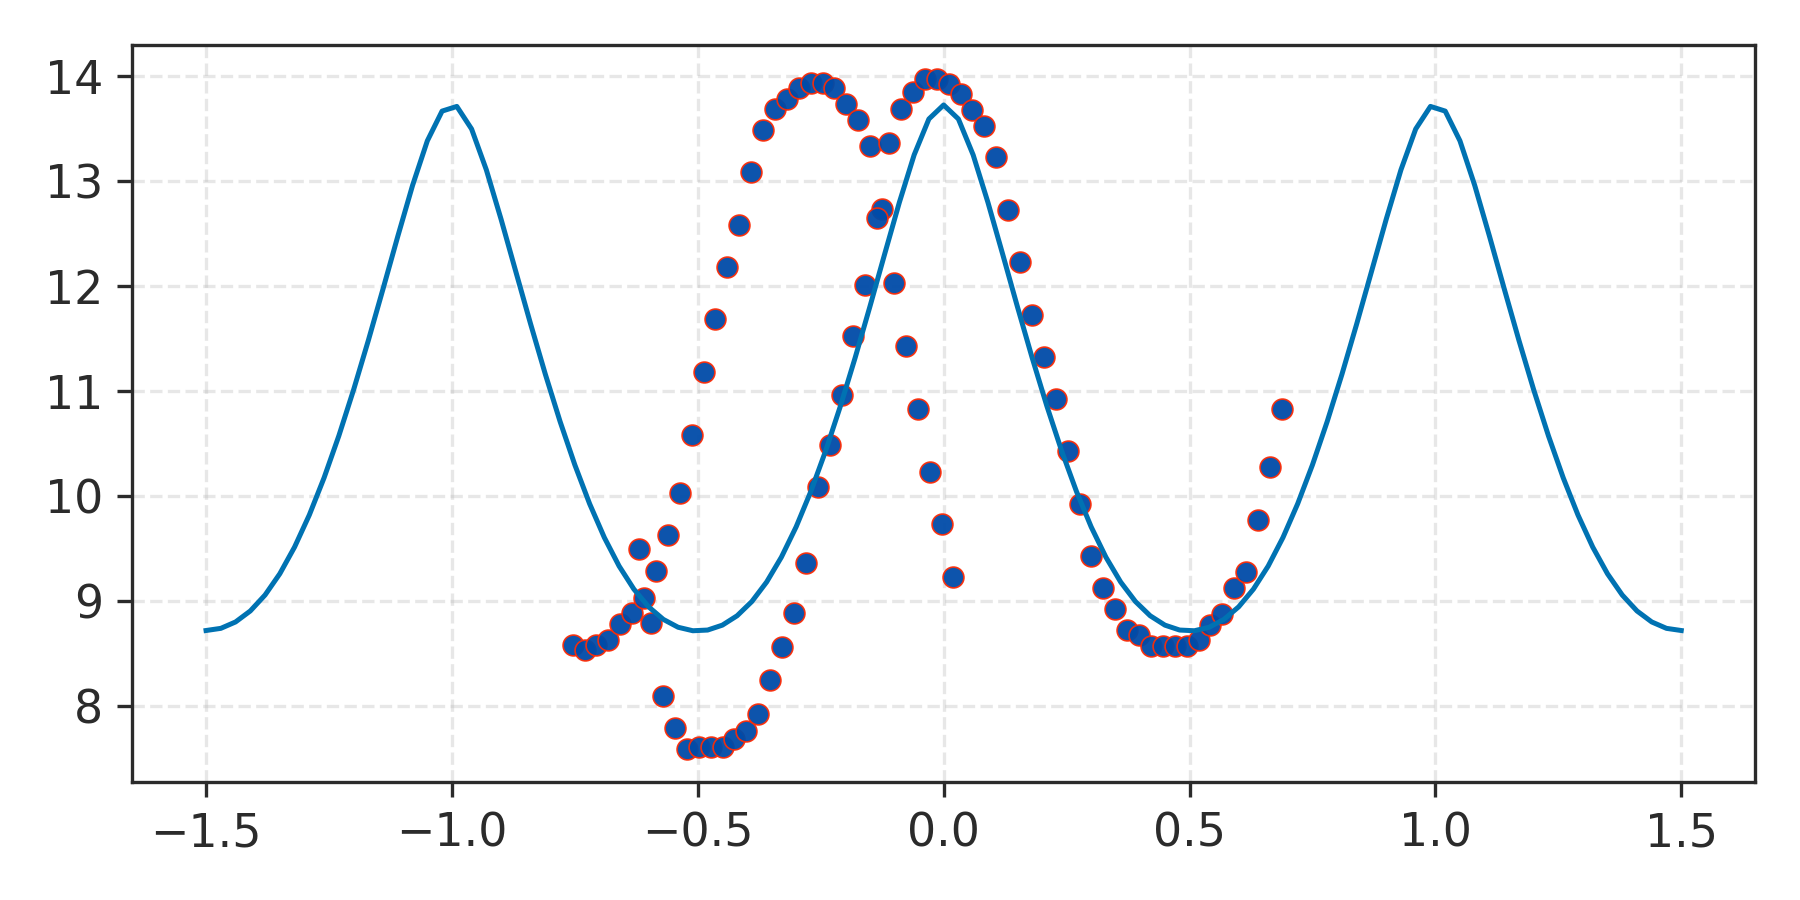

In [6]:
FILES = {
    "A": "#00147f",
    "B": "#ed2200",     # dark red (red2)
    "C": "#ffc125",      # orange,
    "D": "#8b6969",
    "E": "#cd9b1d"
}
data = {}

# Selection of data to fit
series = "A"
scaling = 4.84
offset = 1.85
FILE = "TiN95_TwinQ_3Feb'21_mfield_1-2-3_comb"
data_series = np.loadtxt(f"{BASE_NAME}/{FILE}-{series}.txt")

EL_left = 13
ES = 4.1
ES_on_sides = 7.7
cqps_tqubit.override_parameters(
    EL_left=EL_left,
    EL_right=EL_left,
    ES=ES,
    ES_on_sides=ES_on_sides
)
FLUX_NUMBER = np.linspace(-1.5, 1.5, 101)

# Run simulation
simulation = cqps_tqubit.run_simulation(
    phi_dict={
        "type": "balanced",
        "phi_list": FLUX_NUMBER,
    }, number_of_levels_to_simulate=SIMULATION_PARAMETERS["number_of_levels_to_simulate"],
    use_sparse_matrix=True  # No difference to accuracy
)

# Initial plot
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
data_graph, = ax.plot(data_series[:, 0] * scaling - offset, data_series[:, 1],
                      marker="o",
                      markeredgecolor="#fb2c07",
                      markeredgewidth="0.4",
                      markersize=5,
                      alpha=0.95,
                      linestyle="")
# Double wrapped simulations since there is option to vary phi2
simulation_graph, = ax.plot(
    FLUX_NUMBER, simulation["eigvals"][:, 0, 1] -
    simulation["eigvals"][:, 0, 0],
)

plt.tight_layout()
# ax.set_ylim([0, 10])

# Interactive plot
def cqps_plot(EL_left: float, EL_right: float, ES: float, ES_on_sides: float, scaling: float, offset: float):
    cqps_tqubit.override_parameters(EL_left=EL_left, EL_right=EL_right, ES=ES, ES_on_sides=ES_on_sides)
    simulation = cqps_tqubit.run_simulation(
        phi_dict={
            "type": "balanced",
            "phi_list": FLUX_NUMBER,
        }, number_of_levels_to_simulate=SIMULATION_PARAMETERS["number_of_levels_to_simulate"], use_sparse_matrix=True)
    simulation_graph.set_ydata(
        simulation["eigvals"][:, 0, 1] - simulation["eigvals"][:, 0, 0])
    data_graph.set_xdata(data_series[:, 0] * scaling - offset)


scaling_widget = FloatSlider(
    min=0, max=20, step=0.1,
    description="Scaling", value=scaling,
    layout=Layout(width='90%'),
    continuous_update=False
)
offset_widget = FloatSlider(
    min=-3, max=3, step=0.02,
    description="Offset", value=offset,
    layout=Layout(width='90%'),
    continuous_update=False
)
EL_left_widget = FloatSlider(
    min=0, max=100,
    description="EL_left (GHz)", value=EL_left,
    layout=Layout(width='90%'),
    continuous_update=False
)
EL_right_widget = FloatSlider(
    min=0, max=100,
    description="EL_right (GHz)", value=EL_left,
    layout=Layout(width='90%'),
    continuous_update=False
)
ES_widget = FloatSlider(
    min=0, max=100,
    description="ES (GHz)", value=ES,
    layout=Layout(width='90%'),
    continuous_update=False
)
ES_on_sides_widget = FloatSlider(
    min=0, max=100,
    description="ES_on_sides (GHz)", value=ES_on_sides,
    layout=Layout(width='90%'),
    continuous_update=False
)
ui = widgets.VBox([EL_left_widget, EL_right_widget, ES_widget, ES_on_sides_widget, scaling_widget, offset_widget])
plt.savefig

In [39]:
out = widgets.interactive_output(
    cqps_plot,
    {
        # Key is the subsituted parameter, Values is the widget to use
        "EL_right": EL_right_widget,
        "EL_left": EL_left_widget,
        "ES": ES_widget,
        "ES_on_sides": ES_on_sides_widget,
        "scaling": scaling_widget,
        "offset": offset_widget
    }
)  

display(ui, out)

Output()

## TiN95_TwinQ_3Feb'21_mfield_05_data.vi 

<IPython.core.display.Javascript object>


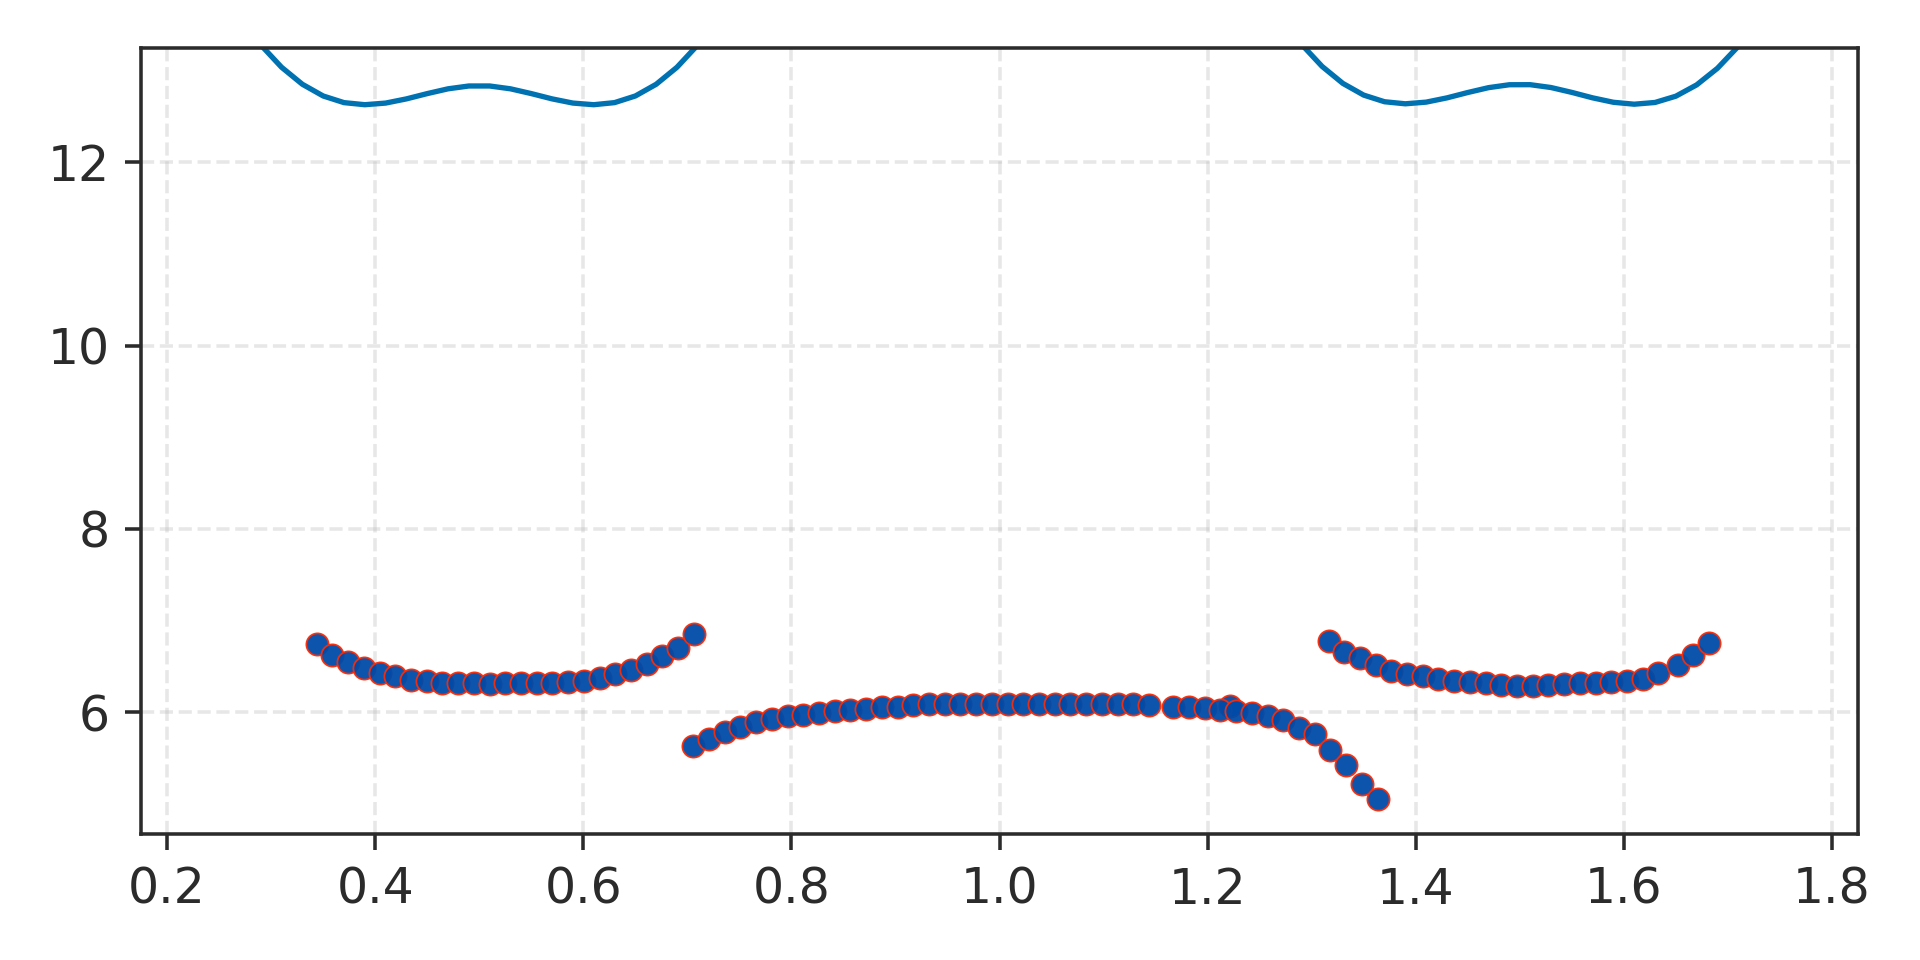

In [94]:
# Selection of data to fit
scaling = 15.1
offset = -0.4
FILE = "TiN95_TwinQ_3Feb'21_mfield_05_data"
data_series = np.loadtxt(f"{BASE_NAME}/{FILE}.txt")

EL_left = 14.2
ES = 5.7
ES_on_sides = 4.6
cqps_tqubit.override_parameters(
    EL_left=EL_left,
    EL_right=EL_left,
    ES=ES,
    ES_on_sides=ES_on_sides
)
FLUX_NUMBER = np.linspace(0.25, 1.75, 76)

# Run simulation
simulation = cqps_tqubit.run_simulation(
    phi_dict={
        "type": "balanced",
        "phi_list": FLUX_NUMBER,
    }, number_of_levels_to_simulate=2,
    use_sparse_matrix=True  # No difference to accuracy
)

# Initial plot
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
data_graph, = ax.plot(data_series[:, 0] * scaling - offset, data_series[:, 1],
                      marker="o",
                      markeredgecolor="#fb2c07",
                      markeredgewidth="0.4",
                      markersize=5,
                      alpha=0.95,
                      linestyle="")
# Double wrapped simulations since there is option to vary phi2
simulation_graph, = ax.plot(
    FLUX_NUMBER, simulation["eigvals"][:, 0, 1] -
    simulation["eigvals"][:, 0, 0],
)

plt.tight_layout()
# ax.set_ylim([0, 10])

# Interactive plot
def cqps_plot(EL_left: float, EL_right: float, ES: float, ES_on_sides: float, scaling: float, offset: float):
    cqps_tqubit.override_parameters(EL_left=EL_left, EL_right=EL_right, ES=ES, ES_on_sides=ES_on_sides)
    simulation = cqps_tqubit.run_simulation(
        phi_dict={
            "type": "balanced",
            "phi_list": FLUX_NUMBER,
        }, number_of_levels_to_simulate=SIMULATION_PARAMETERS["number_of_levels_to_simulate"], use_sparse_matrix=True)
    simulation_graph.set_ydata(
        simulation["eigvals"][:, 0, 1] - simulation["eigvals"][:, 0, 0])
    data_graph.set_xdata(data_series[:, 0] * scaling - offset)


scaling_widget = FloatSlider(
    min=0, max=20, step=0.1,
    description="Scaling", value=scaling,
    layout=Layout(width='90%'),
    continuous_update=False
)
offset_widget = FloatSlider(
    min=-3, max=3, step=0.02,
    description="Offset", value=offset,
    layout=Layout(width='90%'),
    continuous_update=False
)
EL_left_widget = FloatSlider(
    min=0, max=100,
    description="EL_left (GHz)", value=EL_left,
    layout=Layout(width='90%'),
    continuous_update=False
)
EL_right_widget = FloatSlider(
    min=0, max=100,
    description="EL_right (GHz)", value=EL_left,
    layout=Layout(width='90%'),
    continuous_update=False
)
ES_widget = FloatSlider(
    min=0, max=100,
    description="ES (GHz)", value=ES,
    layout=Layout(width='90%'),
    continuous_update=False
)
ES_on_sides_widget = FloatSlider(
    min=0, max=100,
    description="ES_on_sides (GHz)", value=ES_on_sides,
    layout=Layout(width='90%'),
    continuous_update=False
)
ui = widgets.VBox([EL_left_widget, EL_right_widget, ES_widget, ES_on_sides_widget, scaling_widget, offset_widget])

In [95]:
out = widgets.interactive_output(
    cqps_plot,
    {
        # Key is the subsituted parameter, Values is the widget to use
        "EL_right": EL_right_widget,
        "EL_left": EL_left_widget,
        "ES": ES_widget,
        "ES_on_sides": ES_on_sides_widget,
        "scaling": scaling_widget,
        "offset": offset_widget
    }
)  

display(ui, out)

Output()

# Compare to twin flux qubit (retared)

<IPython.core.display.Javascript object>


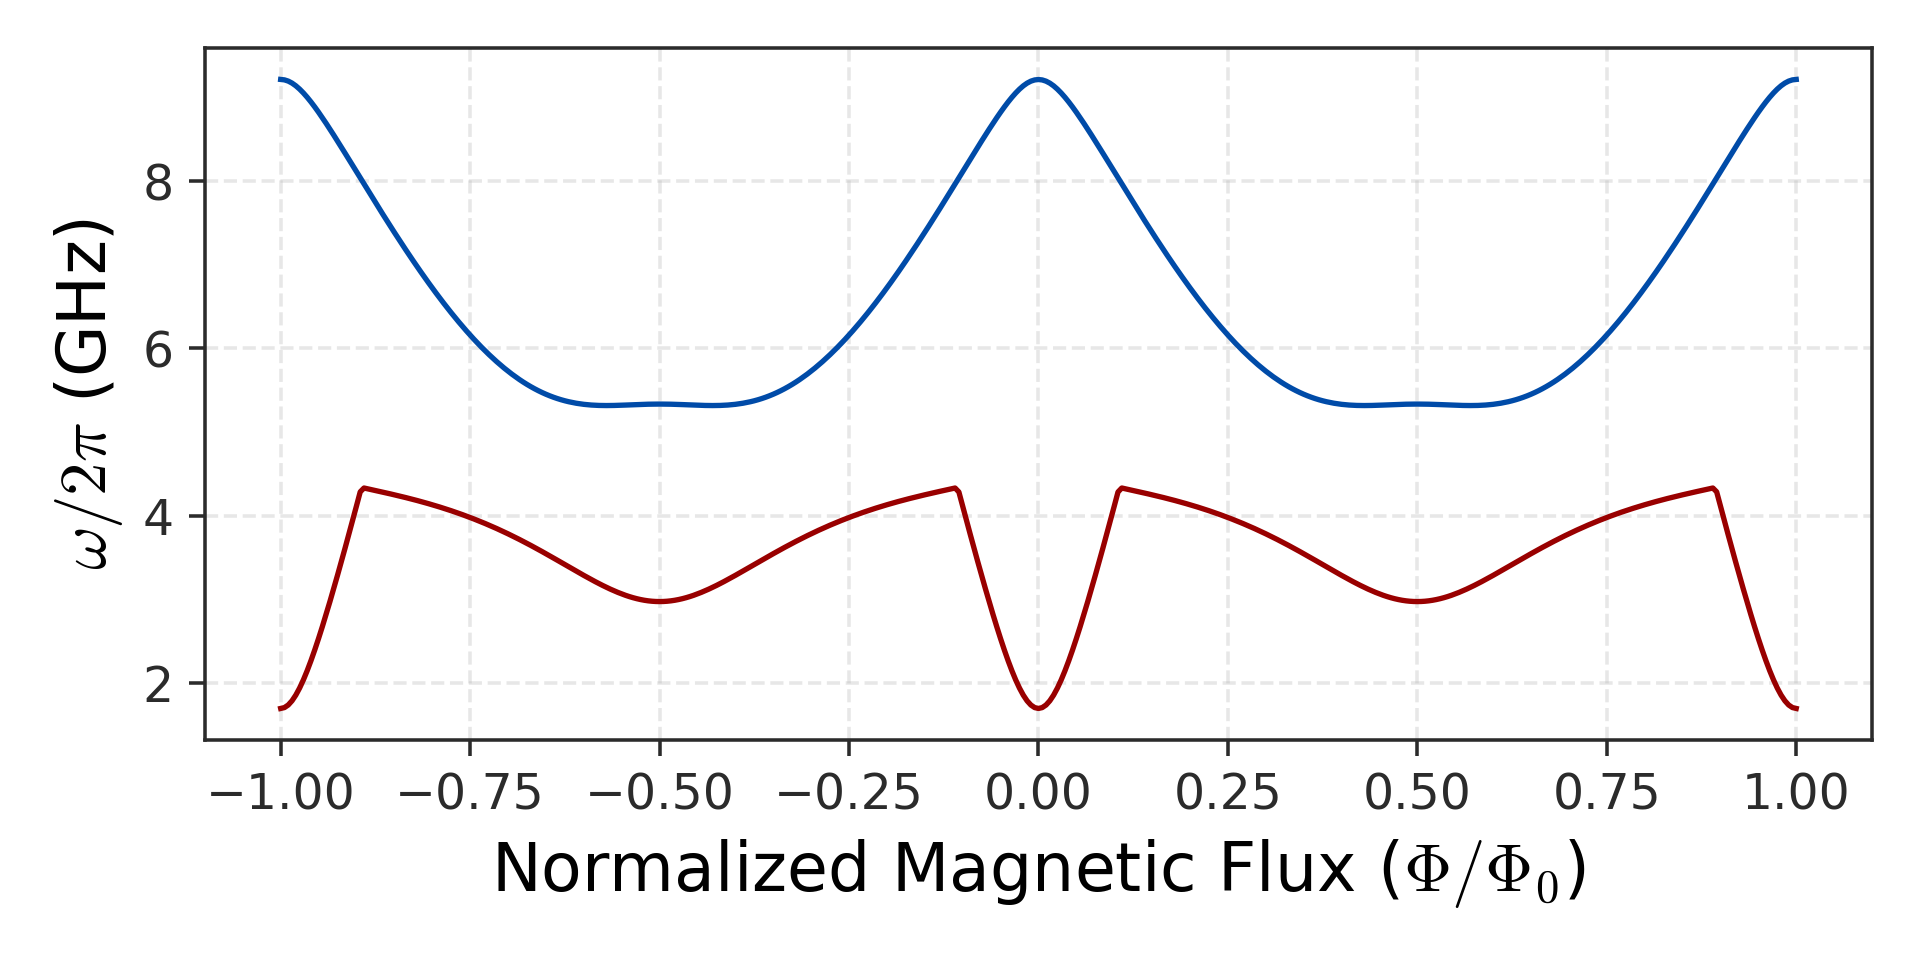

In [89]:
EL_left = 10
ES = 5
ES_on_sides = 4
cqps_tqubit.override_parameters(
    EL_left=EL_left,
    EL_right=EL_left,
    ES=ES,
    ES_on_sides=ES_on_sides
)
FLUX_NUMBER = np.linspace(-1, 1, 401)

# Run simulation
simulation = cqps_tqubit.run_simulation(
    phi_dict={
        "type": "balanced",
        "phi_list": FLUX_NUMBER,
    }, number_of_levels_to_simulate=4,
    use_sparse_matrix=True  # No difference to accuracy
)

# Initial plot
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
# Double wrapped simulations since there is option to vary phi2
simulation_graph, = ax.plot(
    FLUX_NUMBER, simulation["eigvals"][:, 0, 1] -
    simulation["eigvals"][:, 0, 0], color="C0"
)
simulation_graph, = ax.plot(
    FLUX_NUMBER, simulation["eigvals"][:, 0, 2] -
    simulation["eigvals"][:, 0, 1], color="C4"
)

ax.set_xlabel("Normalized Magnetic Flux ($\Phi/\Phi_0$)", fontsize=15)
ax.set_ylabel("$\omega/2\pi$ (GHz)", fontsize=15)    
plt.tight_layout()

plt.savefig(f"./output/2021-03_cqps/cqps_spectrum.svg", transparent=True)

# Integrating profile

In [39]:
SIDE_CONSTRICTION_WIDTH = 0.02
TRIANGLE_IN = [
    # Narrow first
    (1.4, 0.1), 
    # Then flat bar
    (0.47, 0.1)]
TRIANGLE_OUT = [
    # Flat bar
    (0, 0.1),
    (0.47, 0.1),
    # Triangle out
    (1.4, 1.4)
]
SIDE_CONSTRICTION = [
    # Narrow to constriction
    (0, SIDE_CONSTRICTION_WIDTH),
    (0.05, SIDE_CONSTRICTION_WIDTH)
]

def create_loop_profile(loop_profile: list):
    position = [0]
    width = [1.4]
    
    for (l, w) in loop_profile:
        position.append(position[-1] + l)
        width.append(w)
    return (position, width)

## Example plot

In [37]:
constriction = 0.011
(position, width) = create_loop_profile([
    # Wide
    (3.2 + 1.4, 1.4),
    (3.7, 1.4),
    (3.2 + 1.4, 1.4),
    *TRIANGLE_IN,
    *SIDE_CONSTRICTION,
    *TRIANGLE_OUT,
    # Wide
    (3.2 + 1.4, 1.4),
    (3.7, 1.4),
    (3.2 + 1.4, 1.4),
    # Triangle
    *TRIANGLE_IN,
    (0, constriction),
    (0.05, constriction),
    *TRIANGLE_OUT
])
fig, ax = plt.subplots(1, 1, figsize=(6,3))
ax.plot(position, width, color=MY_COLOURS["DarkBlue"])
ax.set_xlabel("$\mu{m}$")
ax.set_ylabel("Width $(\mu{m})$")
plt.tight_layout()

plt.savefig("./data/2021-02-05_cqps/11nm-profile.svg")

<IPython.core.display.Javascript object>

## 11nm

In [43]:
# Then, to evaluate we chop up into separate blocks
(
    # Wide sections
    (3.2 + 1.4 + 3.7 + 3.2 + 1.4 + 3.2 + 1.4 + 3.7 + 1.4) / 1.4
    +
    # Narrowing
    (0.47 + 0.47) / 0.1
    # Constrictions
    + (0.05) / SIDE_CONSTRICTION_WIDTH
    + (0.05) / constriction
    # Triangles
    + 4 * 1.4 * np.log(1.4/0.1) / (1.4 - 0.1)
)

42.35228057178803

## 12nm

In [44]:
constriction = 0.012
(
    # Wide sections
    (1.85 + 3.8 + 1.85 + 1.95 + 5.15 + 0.55) / 1.4
    +
    # Narrowing
    (0.48 + 0.48) / 0.1
    # Constrictions
    + (0.05) / SIDE_CONSTRICTION_WIDTH
    + (0.05) / constriction
    # Triangles
    + 4 * 1.4 * np.log(1.4/0.1) / (1.4 - 0.1)
)

38.45634219643789

## 17nm

In [46]:
constriction = 0.017
(
    # Wide sections
    (1.85 + 7.3 + 1.85 + 1.95 + 8.55 + 0.55) / 1.4
    +
    # Narrowing
    (0.48 + 0.48) / 0.1
    # Constrictions
    + (0.05) / SIDE_CONSTRICTION_WIDTH
    + (0.05) / constriction
    # Triangles
    + 4 * 1.4 * np.log(1.4/0.1) / (1.4 - 0.1)
)

42.15942342893089

## 9nm - joined

In [48]:
constriction = 0.009
(
    # Wide sections
    (4.5 + 4.5 + 10 + 4.5 + 4.5 + 10) / 1.4
    +
    # Narrowing
    (0.48 + 0.48) / 0.1
    # Constrictions
    + (0.05) / SIDE_CONSTRICTION_WIDTH
    + (0.05) / SIDE_CONSTRICTION_WIDTH
    # Triangles
    + 4 * 1.4 * np.log(1.4/0.1) / (1.4 - 0.1)
)

53.1111041011998

## 8nm - joined

In [49]:
constriction = 0.008
(
    # Wide sections
    (4.5 + 4.5 + 10.2 + 4.5 + 4.5 + 10.2) / 1.4
    +
    # Narrowing
    (0.48 + 0.48) / 0.1
    # Constrictions
    + (0.05) / SIDE_CONSTRICTION_WIDTH
    + (0.05) / SIDE_CONSTRICTION_WIDTH
    # Triangles
    + 4 * 1.4 * np.log(1.4/0.1) / (1.4 - 0.1)
)

53.396818386914084

# Spectrum plots

<IPython.core.display.Javascript object>


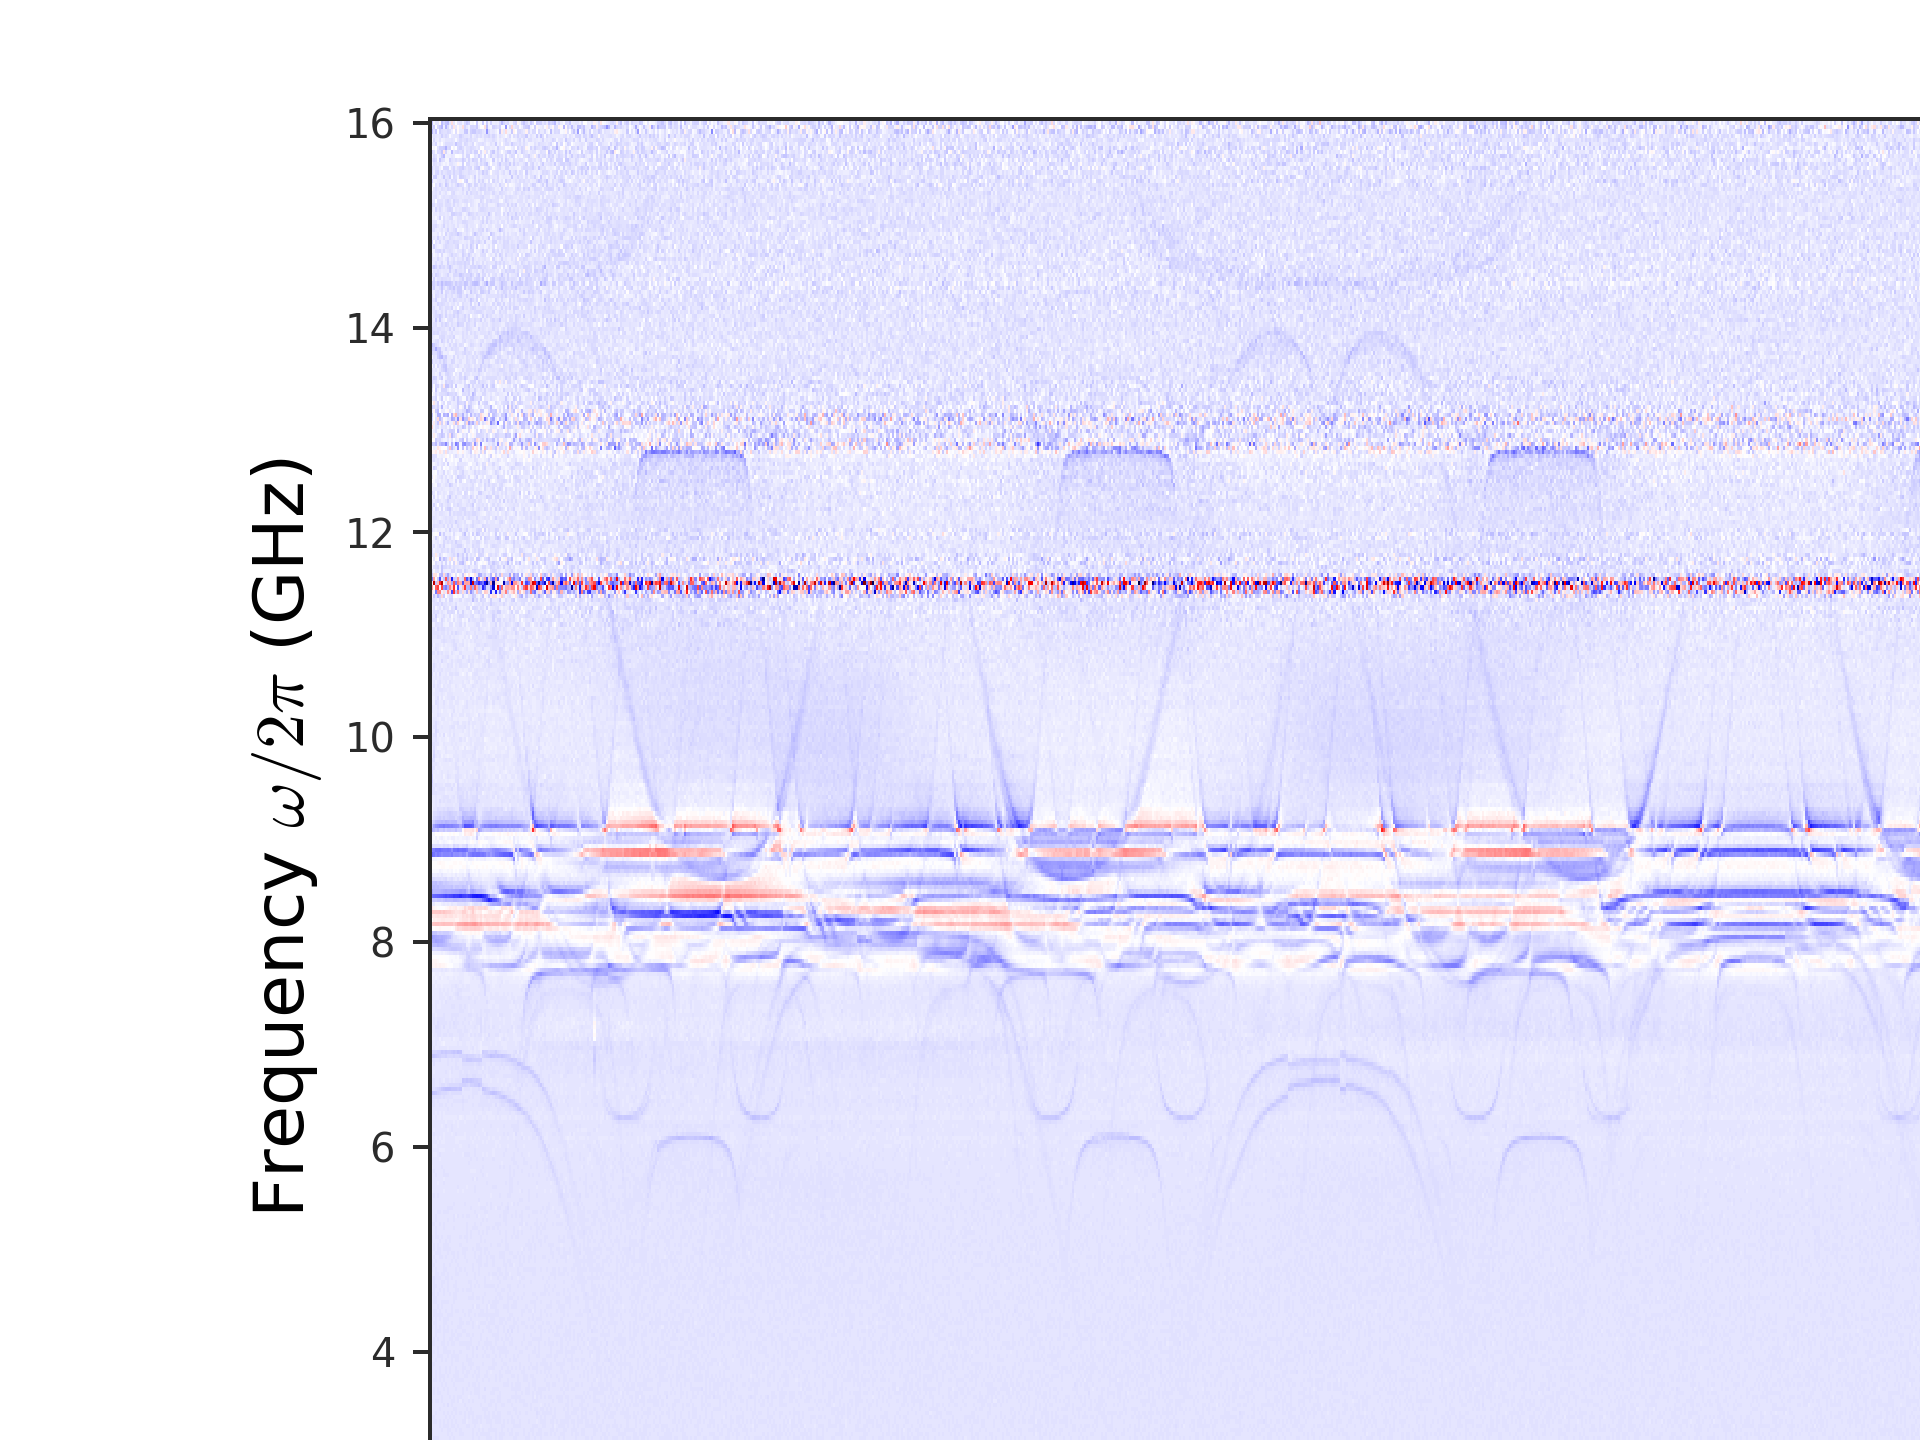

In [35]:
# FILENAME = "./data/2021-02-05_cqps/TiN95_TwinQ_3Feb'21_mfield_06_data-C.txt"
FILENAME = "./data/2021-02-05_cqps/TiN95_TwinQ_3Feb'21_mfield_04.txt"

with open(FILENAME) as fin:
    data3d_z = np.transpose(np.loadtxt(FILENAME))
    
    first_line = fin.readline().split()
    data3d_x = np.linspace(float(first_line[1]), float(first_line[2]), data3d_z.shape[1])
    data3d_x = data3d_x
    
    second_line = fin.readline().split()
    data3d_y = np.linspace(float(second_line[1]), float(second_line[2]), data3d_z.shape[0])

# Build meshes and arrays based of the ranges in the file
data3d_xmesh, data3d_ymesh = np.meshgrid(data3d_x, data3d_y)

# Initial plot
fig, ax_arr = plt.subplots(1, 1, figsize=(4, 3))
ax = ax_arr
ax.pcolormesh(data3d_xmesh, data3d_ymesh, data3d_z,
              shading='nearest',
              cmap=cm.seismic)

ax.set_xlim([data3d_x[0], data3d_x[-1]])
ax.set_ylim([data3d_y[0], data3d_y[-1]])
# ax.set_ylim([10, 15])
ax.set_xlabel("Field Current (mA)")
ax.set_ylabel("Frequency $\omega/2\pi$ (GHz)")
plt.tight_layout()
plt.savefig(FILENAME.replace(".txt", ".png"), dpi=300)

<IPython.core.display.Javascript object>


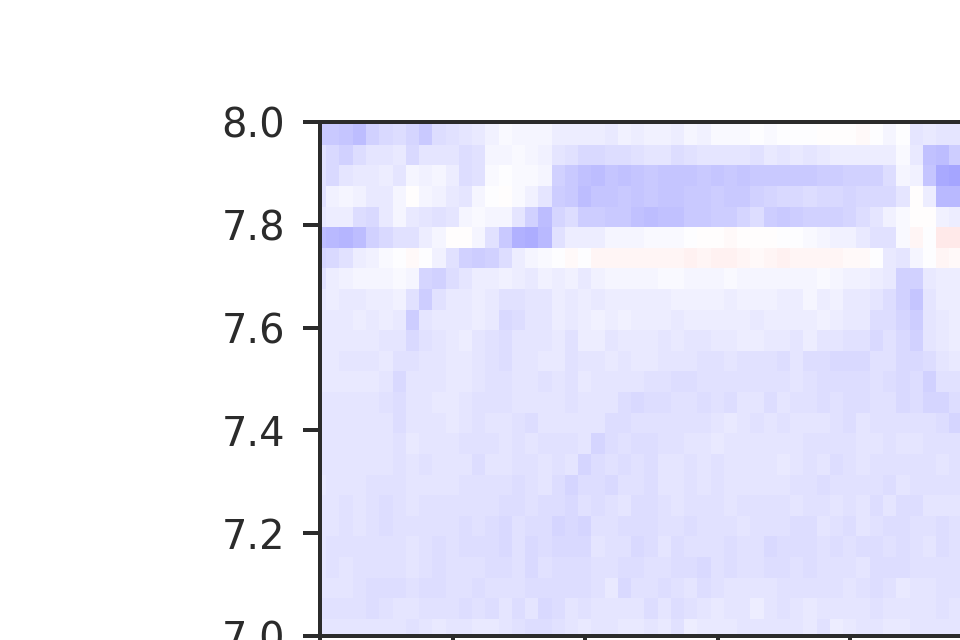

In [57]:
FILENAME = "./data/2021-02-05_cqps/TiN95_TwinQ_3Feb'21_mfield_04_data-F.txt"

fig, ax_arr = plt.subplots(1, 1, figsize=(2, 4/3))
ax = ax_arr
ax.pcolormesh(data3d_xmesh, data3d_ymesh, data3d_z,
              shading='nearest',
              cmap=cm.seismic)

ax.set_xlim([0.3, 0.36])
ax.set_ylim([7, 8])
plt.tight_layout()
plt.savefig(FILENAME.replace(".txt", ".png"), dpi=300, transparent=True)

<IPython.core.display.Javascript object>


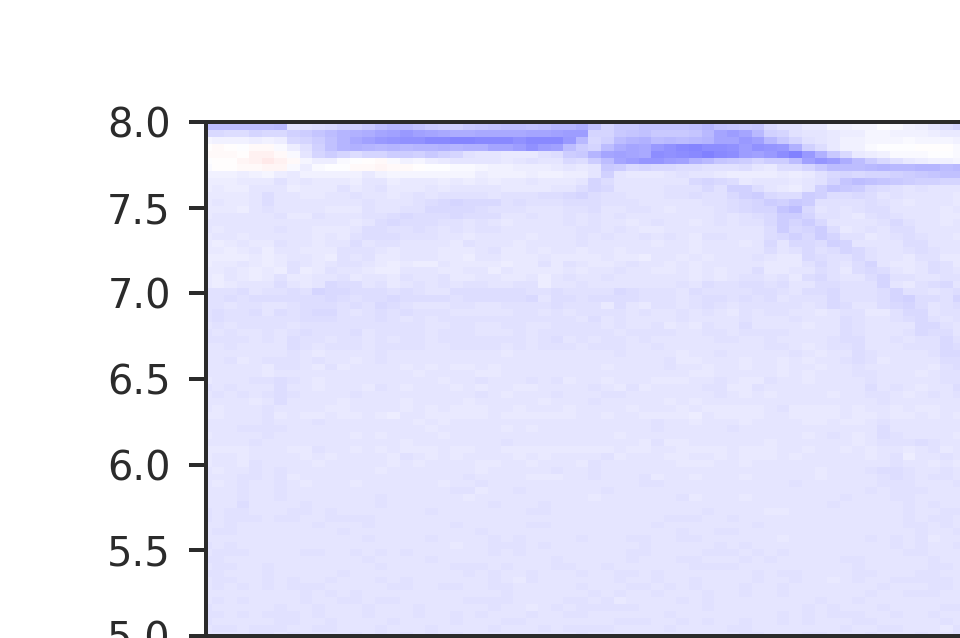

In [54]:
FILENAME = "./data/2021-02-05_cqps/TiN95_TwinQ_3Feb'21_mfield_04_data-D.txt"

fig, ax_arr = plt.subplots(1, 1, figsize=(2, 4/3))
ax = ax_arr
ax.pcolormesh(data3d_xmesh, data3d_ymesh, data3d_z,
              shading='nearest',
              cmap=cm.seismic)

ax.set_xlim([-0.27, -0.2])
ax.set_ylim([5, 8])
plt.tight_layout()
plt.savefig(FILENAME.replace(".txt", ".png"), dpi=300, transparent=True)

<IPython.core.display.Javascript object>


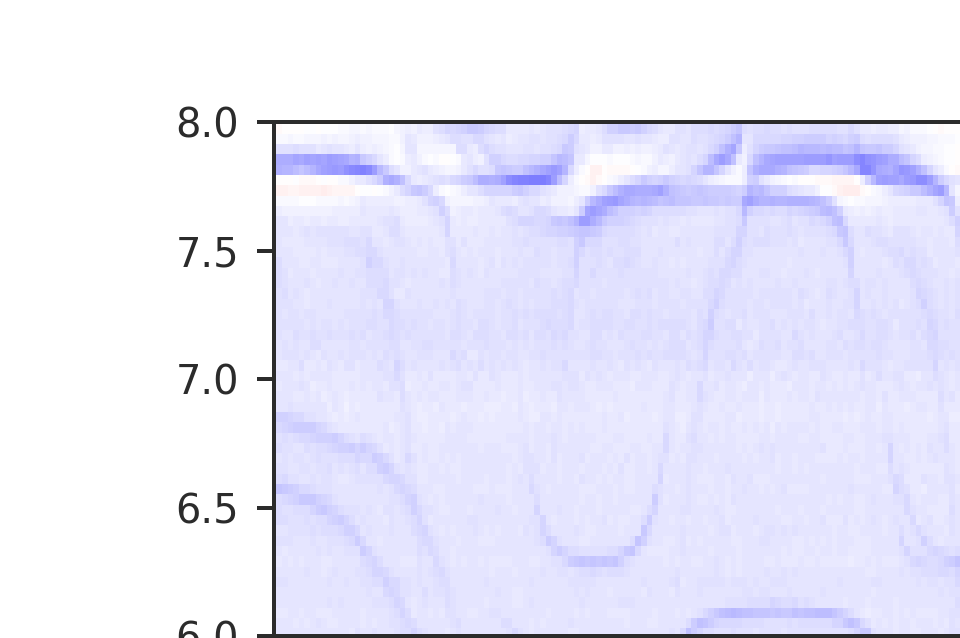

In [52]:
FILENAME = "./data/2021-02-05_cqps/TiN95_TwinQ_3Feb'21_mfield_04_data-E.txt"

fig, ax_arr = plt.subplots(1, 1, figsize=(2, 4/3))
ax = ax_arr
ax.pcolormesh(data3d_xmesh, data3d_ymesh, data3d_z,
              shading='nearest',
              cmap=cm.seismic)

ax.set_xlim([-0.05, 0.1])
ax.set_ylim([6, 8])
plt.tight_layout()
plt.savefig(FILENAME.replace(".txt", ".png"), dpi=300, transparent=True)

<IPython.core.display.Javascript object>


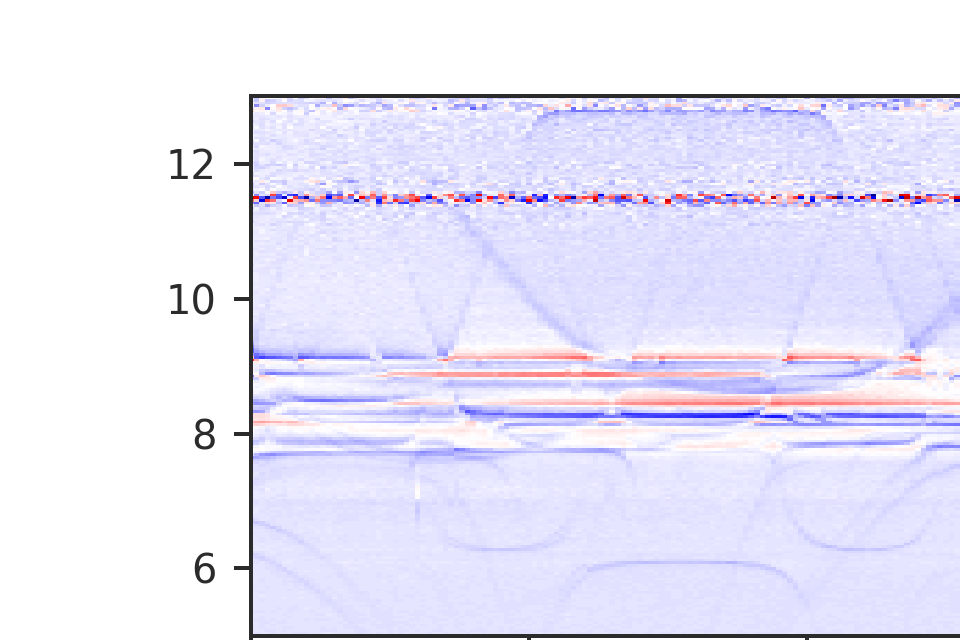

In [47]:
FILENAME = "./data/2021-02-05_cqps/TiN95_TwinQ_3Feb'21_mfield_04_data-C.txt"

# Initial plot
fig, ax_arr = plt.subplots(1, 1, figsize=(2, 4/3))
ax = ax_arr
ax.pcolormesh(data3d_xmesh, data3d_ymesh, data3d_z,
              shading='nearest',
              cmap=cm.seismic)

ax.set_xlim([-0.45, -0.3])
ax.set_ylim([5, 13])
# ax.set_xlabel("I (mA)")
# ax.set_ylabel("$\omega/2\pi$ (GHz)")
plt.tight_layout()
plt.savefig(FILENAME.replace(".txt", ".png"), dpi=300, transparent=True)

<IPython.core.display.Javascript object>


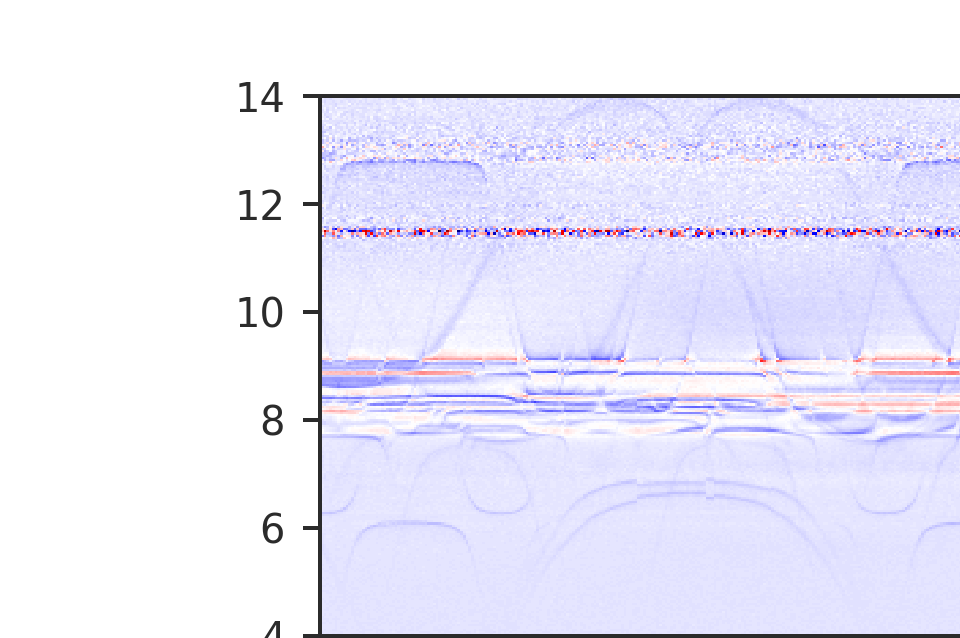

In [48]:
FILENAME = "./data/2021-02-05_cqps/TiN95_TwinQ_3Feb'21_mfield_04_data-B.txt"

# Initial plot
fig, ax_arr = plt.subplots(1, 1, figsize=(2, 4/3))
ax = ax_arr
ax.pcolormesh(data3d_xmesh, data3d_ymesh, data3d_z,
              shading='nearest',
              cmap=cm.seismic)

ax.set_xlim([-0.2, 0.1])
ax.set_ylim([4, 14])
# ax.set_xlabel("I (mA)")
# ax.set_ylabel("$\omega/2\pi$ (GHz)")
plt.tight_layout()
plt.savefig(FILENAME.replace(".txt", ".png"), dpi=300, transparent=True)

# Smith fitting

In [150]:
from scipy.optimize import curve_fit
import ipywidgets

def transmission_model(w, wc, Omega, Gamma1, Gamma2):
    """
    __ Description __
    Fits Rabi oscillations of the format
    A e^(-t/tDec) cos(2π t / T + B) + C
    """
    dw = wc - w
    r0 = Gamma1 / (2 * Gamma2)
#     r0 = 1
    
    reflection = r0 / (1 + (dw/Gamma2)**2 + Omega**2/(Gamma1*Gamma2))
    real = reflection
    imag = - reflection * dw / Gamma2
    
    return (real,  imag)

In [263]:
def from_dB_to_vGain(dB):
    return 10**(dB / 20)

RT = -30
IN = -60
AMP = 35 + 65

SCALING = RT + IN + AMP

SCALING_CORRECTION = from_dB_to_vGain(SCALING)
from_dB_to_vGain(5) * 0.031

0.05512666171120661

<IPython.core.display.Javascript object>


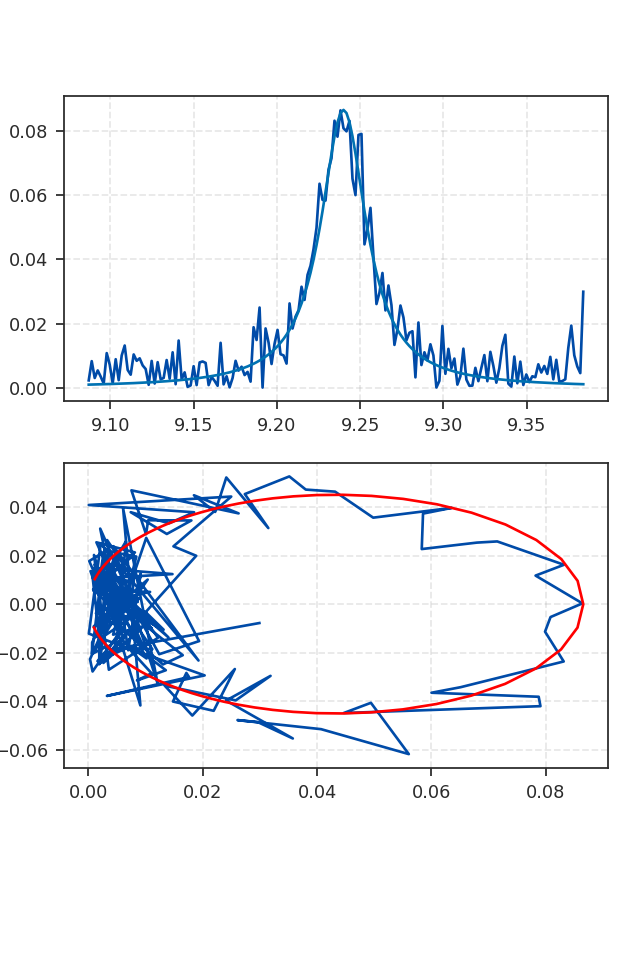

In [280]:
FILENAME = "./data/2021-02-05_cqps/TiN95_TwinQ_3Feb'21_smith_09_-55dBm"
# FILENAME = "./data/2021-02-05_cqps/TiN95_TwinQ_3Feb'21_smith_09_-50dBm"
# FILENAME = "./data/2021-02-05_cqps/TiN95_TwinQ_3Feb'21_smith_09_-45dBm"
# FILENAME = "./data/2021-02-05_cqps/TiN95_TwinQ_3Feb'21_smith_09_-40dBm"
# FILENAME = "./data/2021-02-05_cqps/TiN95_TwinQ_3Feb'21_smith_09_-35dBm"
# FILENAME = "./data/2021-02-05_cqps/TiN95_TwinQ_3Feb'21_smith_09_-30dBm"
# FILENAME = "./data/2021-02-05_cqps/TiN95_TwinQ_3Feb'21_smith_09_-25dBm"
# FILENAME = "./data/2021-02-05_cqps/TiN95_TwinQ_3Feb'21_smith_09_-20dBm"
# FILENAME = "./data/2021-02-05_cqps/TiN95_TwinQ_3Feb'21_smith_09_-15dBm"
# FILENAME = "./data/2021-02-05_cqps/TiN95_TwinQ_3Feb'21_smith_09_-10dBm"

DATA = np.loadtxt(f"{FILENAME}-re.txt", skiprows=1)
DATA_f = DATA[:, 0] / GHz
re = DATA[:, 1]
DATA = np.loadtxt(f"{FILENAME}-im.txt", skiprows=1)
im = DATA[:, 1]
amplitude = np.sqrt(re**2 + im**2)
phase = np.arctan(im/re)

wc = 9.24
Omega = 0.002
Gamma1 = 0.003
Gamma2 = 0.016

phase_corr = 0
scaling_corr = 1/SCALING_CORRECTION
sim = transmission_model(DATA_f, wc, Omega, Gamma1, Gamma2)
    
# Plotting
fix, ax = plt.subplots(2, 1, figsize=(4, 6))

re_raw, = ax[0].plot(DATA_f, scaling_corr*amplitude * np.cos(phase+phase_corr))
re_sim, = ax[0].plot(DATA_f, sim[0])

# ax[1].plot(DATA_f, im)
# im_plot, = ax[1].plot(DATA_f, sim[1])
circ_raw, = ax[1].plot(scaling_corr*amplitude * np.cos(phase+phase_corr),
                       scaling_corr*amplitude * np.sin(phase+phase_corr))
circ_sim, = ax[1].plot(sim[0], sim[1], color='red')

def update(wc, Omega, Gamma1, Gamma2, phase_corr, scaling_corr):
    simulation = transmission_model(DATA_f, wc, Omega, Gamma1, Gamma2)
    re_sim.set_ydata(simulation[0])
    circ_sim.set_xdata(simulation[0])
    circ_sim.set_ydata(simulation[1])
    
    _re = scaling_corr*amplitude * np.cos(phase+phase_corr)
    _im = scaling_corr*amplitude * np.sin(phase+phase_corr)
    re_raw.set_ydata(_re)
    circ_raw.set_xdata(_re)
    circ_raw.set_ydata(_im)
    
    ax[0].relim()
    ax[0].autoscale_view()
    ax[1].relim()
    ax[1].autoscale_view()

In [265]:
CONTINUOUS_UPDATE = False
wc_widget = ipywidgets.FloatText(
    min=9.2, max=9.4,
    description="$\omega_0$ (GHz)", value=wc,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
Omega_widget = ipywidgets.FloatText(
    min=0, max=1,
    description="$Omega$ (GHz)", value=Omega,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
Omega_widget.style.handle_color = 'red'
Gamma1_widget = ipywidgets.FloatSlider(
    min=0, max=0.03, step=0.0001,
    description="$\Gamma_1$ (GHz)", value=Gamma1,
    readout_format='.4f',
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
Gamma1_widget.style.handle_color = 'blue'
Gamma2_widget = ipywidgets.FloatSlider(
    min=0, max=0.03, step=0.0001,
    readout_format='.4f',
    description="$\Gamma_2$ (GHz)", value=Gamma2,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
Gamma2_widget.style.handle_color = 'blue'
phase_widget = ipywidgets.FloatSlider(
    min=0, max=2*np.pi, step=0.0001,
    readout_format='.4f',
    description="Phase", value=phase_corr,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
phase_widget.style.handle_color = 'green'
scale_widget = ipywidgets.FloatSlider(
    min=0, max=1.5, step=0.0001,
    readout_format='.4f',
    description="Scale", value=scaling_corr,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
scale_widget.style.handle_color = 'green'

ui = ipywidgets.GridspecLayout(6, 1)
ui[0,:] = wc_widget
ui[1,:] = Omega_widget
ui[2,:] = Gamma1_widget
ui[3,:] = Gamma2_widget
ui[4,:] = phase_widget
ui[5,:] = scale_widget


out = ipywidgets.interactive_output(
    update,
    {
        # Key is the subsituted parameter, Values is the widget to use
        "wc": wc_widget,
        "Omega": Omega_widget,
        "Gamma1": Gamma1_widget,
        "Gamma2": Gamma2_widget,
        "phase_corr": phase_widget,
        "scaling_corr": scale_widget
#         "INDEX": INDEX_widget,
#         "cut": CUT_widget,
#         "user_toggle": user_toggle_widget,
#         "fit_toggle": fit_toggle_widget
    }
)

display(ui, out)

GridspecLayout(children=(FloatText(value=9.245, description='$\\omega_0$ (GHz)', layout=Layout(grid_area='widg…

Output()

<IPython.core.display.Javascript object>


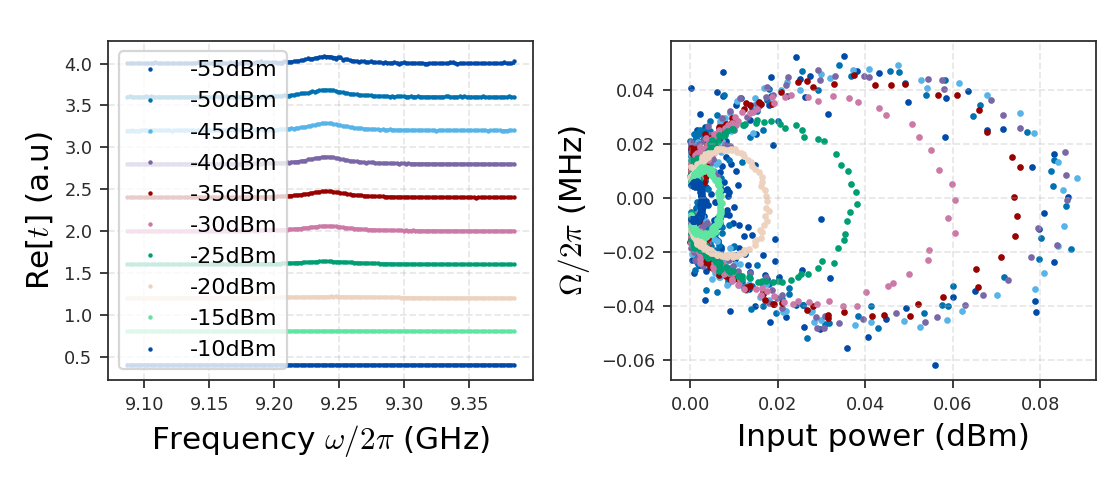

In [287]:
transmission_fits = {
   -55: (9.24, 0.002, 0.003, 0.016),#
   -50: (9.24, 0.002, 0.003, 0.016),#
   -45: (9.24, 0.002, 0.003, 0.016),#
   -40: (9.24, 0.002, 0.003, 0.016),#
   -35: (9.24, 0.0035, 0.003, 0.016),#
   -30: (9.24, 0.0064, 0.0034, 0.016),#
   -25: (9.24, 0.01, 0.0034, 0.0164),#
   -20: (9.245, 0.0171, 0.0035, 0.0164),#
   -15: (9.245, 0.031, 0.0037, 0.0182),#
   -10: (9.25, 0.055, 0.0041, 0.0213),#
}
# When normalised amplitude by 1
# transmission_fits = {
#    -55: (9.24, 0.009, 0.013, 0.0016),#
# #    -50: (9.24, 0.009, 0.013, 0.0016),#
# #    -45: (9.24, 0.11, 0.014, 0.0015),#
# #    -40: (9.24, 0.11, 0.014, 0.0015),#
# #    -35: (9.24, 0.12, 0.014, 0.0015),#
# #    -30: (9.24, 0.11, 0.014, 0.0015),#
# #    -25: (9.241, 0.15, 0.017, 0.0016),#
# #    -20: (9.242, 0.26, 0.023, 0.019),#
# #    -15: (9.247, 0.45, 0.028, 0.02),#
# #    -10: (9.255, 0.82, 0.04, 0.026),#
# }

fix, ax_arr = plt.subplots(1, 2, figsize=(7, 3))

ax = ax_arr[0]
TOP = 4
STEP = TOP/10
for i, key in enumerate(transmission_fits.keys()):
    DATA = np.loadtxt(f"./data/2021-02-05_cqps/TiN95_TwinQ_3Feb'21_smith_09_{key}dBm-re.txt", skiprows=1)
    re = DATA[:, 1]
    DATA = np.loadtxt(f"./data/2021-02-05_cqps/TiN95_TwinQ_3Feb'21_smith_09_{key}dBm-im.txt", skiprows=1)
    im = DATA[:, 1]
    amplitude = np.sqrt(re**2 + im**2)
    phase = np.arctan(im/re)
    _re = scaling_corr*amplitude * np.cos(phase)
    _im = scaling_corr*amplitude * np.sin(phase)
    ax.plot(
        DATA_f, 
        TOP-i*STEP + _re,
#         TOP-i*STEP + np.loadtxt(
#             f"./data/2021-02-05_cqps/TiN95_TwinQ_3Feb'21_smith_09_{key}dBm-re.txt", 
#             skiprows=1)[:,1],
        label=f"{key}dBm",
        linestyle="",
        marker="o", markersize=1, color=f"C{i}"
    )
    ax.plot(
        DATA_f,
        TOP - i*STEP + transmission_model(DATA_f, *transmission_fits[key])[0],
        color=f"C{i}"
    )
    ATTENUATION = 60
    ax_arr[1].scatter(_re, _im, color=f"C{i}")
#     ax_arr[1].scatter([key - 40], [1000*transmission_fits[key][1]], color=f"C{i}")
    
ax.set_xlabel("Frequency $\omega/2\pi$ (GHz)")
ax.set_ylabel("Re[$t$] (a.u)")
ax.legend(loc="lower left")

ax_arr[1].set_ylabel("$\Omega/2\pi$ (MHz)")
ax_arr[1].set_xlabel("Input power (dBm)")

plt.tight_layout()
# dBm_list = np.linspace(-55, -10, 10)
# def from_dBm(array):
#     return np.power(10, array / 10)
# ax.plot(dBm_list, from_dBm(dBm_list))

# axt = ax.twinx()
# axt.plot(transmission_fits.keys(), [i[1] for i in transmission_fits.values()], marker='o')
# plt.savefig("./data/2021-02-05_cqps/twin-cqps_smith09_fitting.pdf")

<IPython.core.display.Javascript object>


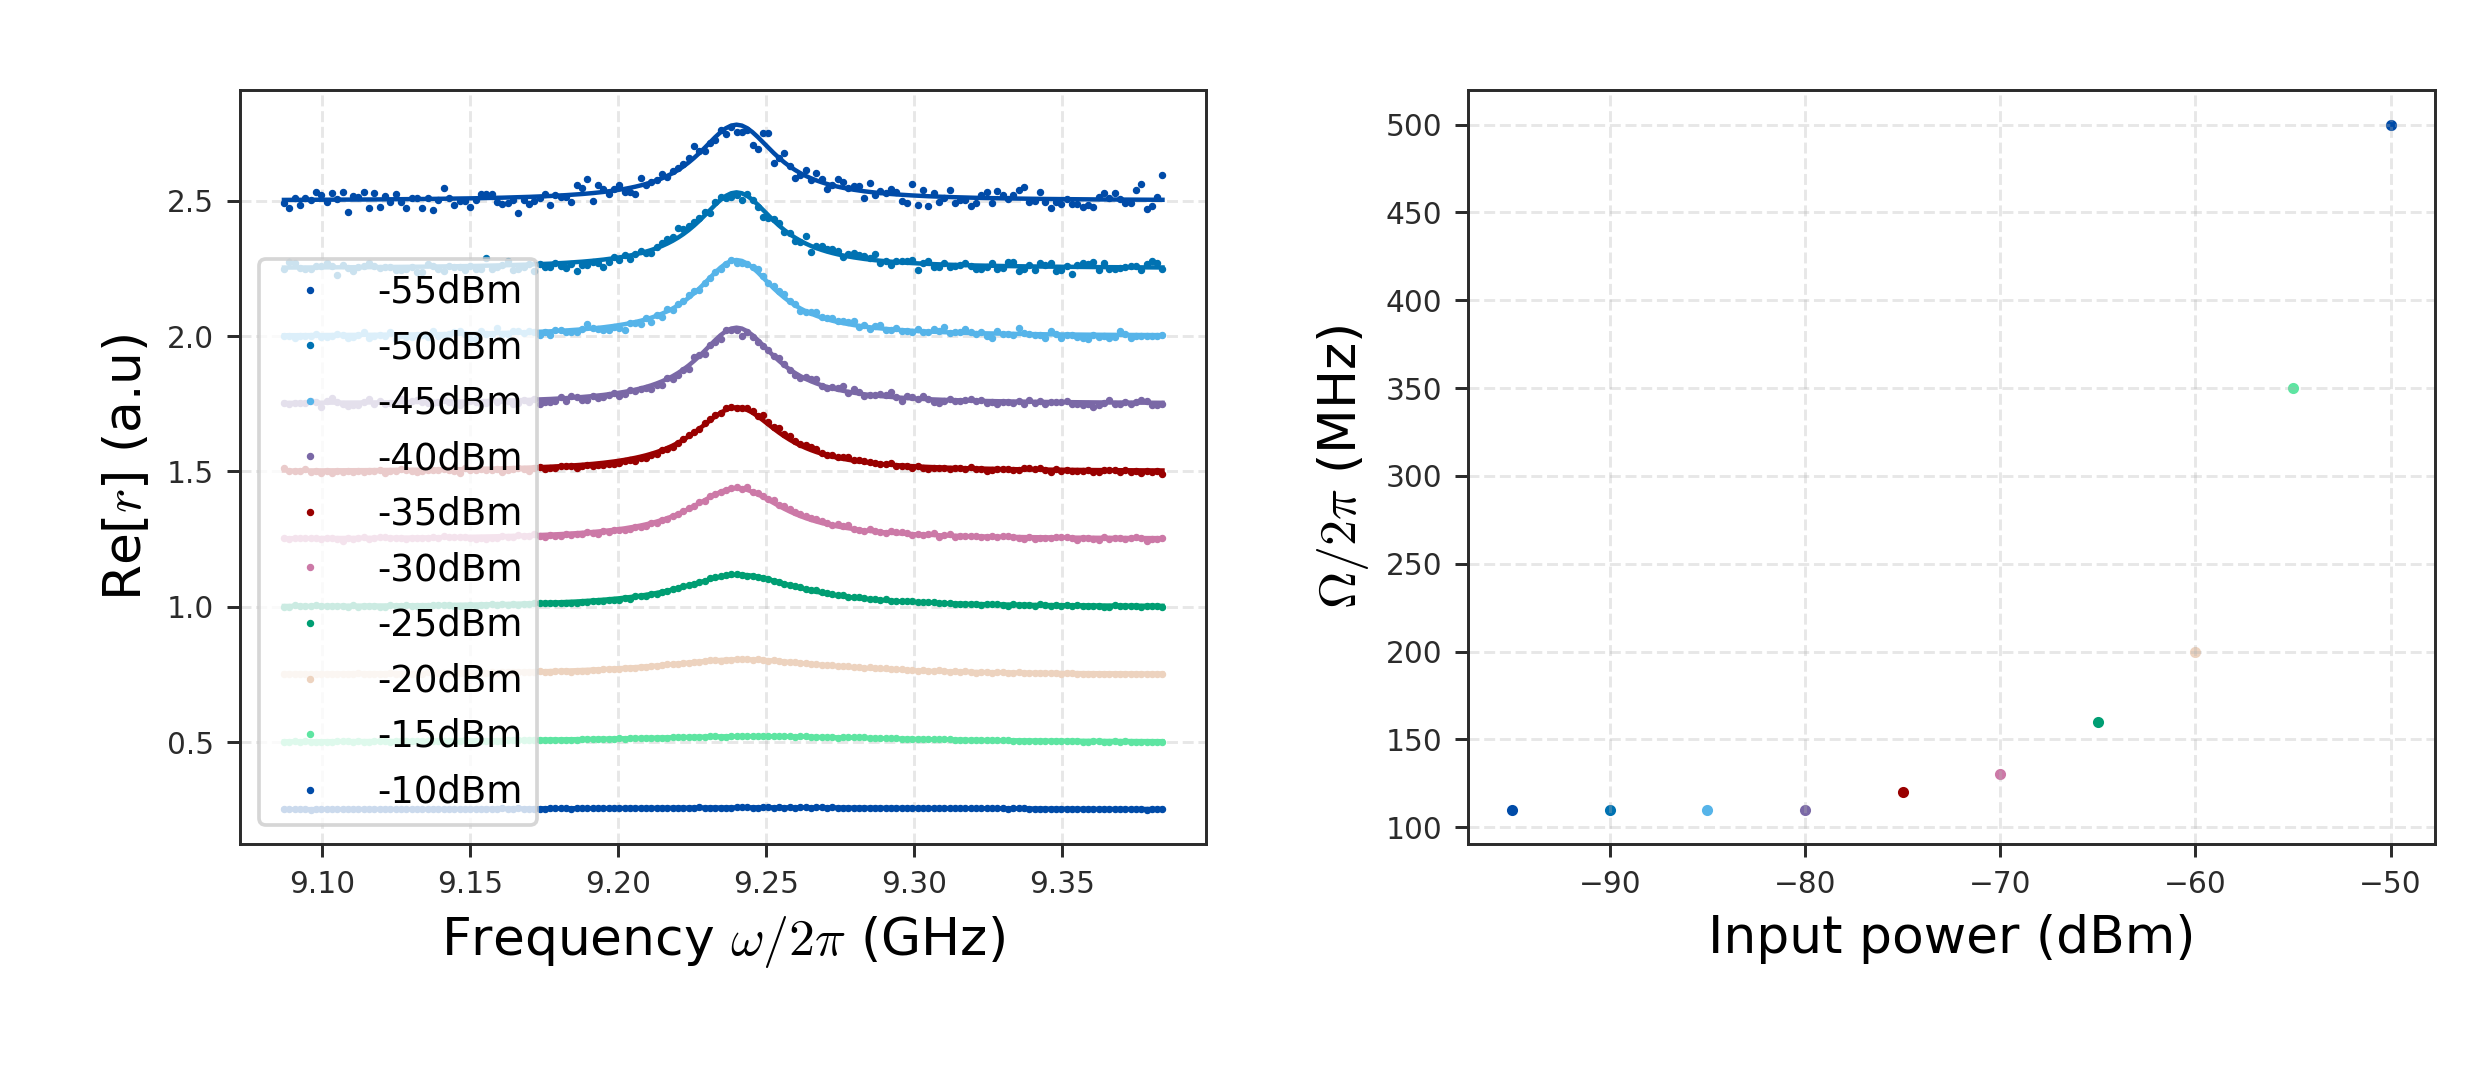

In [277]:
transmission_fits = {
   -55: (9.24, 0.11, 0.083, 0.0018),
   -50: (9.24, 0.11, 0.083, 0.0018),
   -45: (9.24, 0.11, 0.083, 0.0018),
   -40: (9.24, 0.11, 0.083, 0.0018),
   -35: (9.24, 0.12, 0.083, 0.0018),
   -30: (9.24, 0.13, 0.08, 0.0018),
   -25: (9.241, 0.16, 0.078, 0.0018),
#    -40: (9.24, 0.15, 0.111, 0.0014),
#    -35: (9.24, 0.15, 0.105, 0.0014),
#    -30: (9.24, 0.20, 0.126, 0.0012),
#    -25: (9.241, 0.25, 0.121, 0.001),
#    -20: (9.242, 0.3, 0.099, 0.001),
   -20: (9.242, 0.2, 0.067, 0.002),
   -15: (9.245, 0.35, 0.073, 0.002),
   -10: (9.25, 0.5, 0.066, 0.002),
}

fix, ax_arr = plt.subplots(1, 2, figsize=(7, 3))

ax = ax_arr[0]
for i, key in enumerate(transmission_fits.keys()):
    ax.plot(
        DATA_f, 
        2.5-i*0.25 + np.loadtxt(
            f"./data/2021-02-05_cqps/TiN95_TwinQ_3Feb'21_smith_09_{key}dBm-re.txt", 
            skiprows=1)[:,1],
        label=f"{key}dBm",
        linestyle="",
        marker="o", markersize=1, color=f"C{i}"
    )
    ax.plot(
        DATA_f,
        2.5 - i*0.25 + transmission_model(DATA_f, *transmission_fits[key])[0],
        color=f"C{i}"
    )
    ATTENUATION = 40
    ax_arr[1].scatter([key - 40], [1000*transmission_fits[key][1]], color=f"C{i}")
    
ax.set_xlabel("Frequency $\omega/2\pi$ (GHz)")
ax.set_ylabel("Re[$r$] (a.u)")
ax.legend(loc="lower left")
ax_arr[1].set_ylabel("$\Omega/2\pi$ (MHz)")
ax_arr[1].set_xlabel("Input power (dBm)")

plt.tight_layout()

# dBm_list = np.linspace(-55, -10, 10)
# def from_dBm(array):
#     return np.power(10, array / 10)
# ax.plot(dBm_list, from_dBm(dBm_list))

# axt = ax.twinx()
# axt.plot(transmission_fits.keys(), [i[1] for i in transmission_fits.values()], marker='o')
plt.savefig("./data/2021-02-05_cqps/twin-cqps_smith09_fitting.pdf")